In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import LogFormatter
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import json
import plategig
import re

PROJECT_PATH = Path('/project/greencenter/Toprak_lab/shared/plategig/projects')
PROJECT_ID = 'Tested_Variants_MIC_Estimations'

#### Step 1: Read Plate Information

In [11]:
# Read the Excel file into a DataFrame
df_plate_info = pd.read_excel(PROJECT_PATH / PROJECT_ID / 'data' / 'PlateInfo_250508_250510_250407.xlsx', engine='openpyxl')
df_plate_info.rename(columns={'Plate': 'Plate_ID'}, inplace=True)
df_plate_info

Experiment  Plate_ID Well      Strain  Culture  Replicate Antibiotic  \
0              1         1   A1  Media Only      NaN        NaN        NaN   
1              1         1   A2  Media Only      NaN        NaN        NaN   
2              1         1   A3  Media Only      NaN        NaN        NaN   
3              1         1   A4  Media Only      NaN        NaN        NaN   
4              1         1   A5  Media Only      NaN        NaN        NaN   
...          ...       ...  ...         ...      ...        ...        ...   
3547           1        37   H8  Media Only      NaN        NaN        NaN   
3548           1        37   H9  Media Only      NaN        NaN        NaN   
3549           1        37  H10  Media Only      NaN        NaN        NaN   
3550           1        37  H11  Media Only      NaN        NaN        NaN   
3551           1        37  H12  Media Only      NaN        NaN        NaN   

      Dose  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
...    ...  
3547   NaN  
3548   NaN  
3549   NaN  
3550   NaN  
3551   NaN  

[3552 rows x 8 columns]

Collect unique plate IDs

#### Step 2: Read the raw OD data

In [12]:
df_OD_raw = pd.read_excel(PROJECT_PATH / PROJECT_ID / 'data' /'ODFinal_250508_250510_250407.xlsx')
# drop last nan column, fix to input mistake
df_OD_raw = df_OD_raw.iloc[:,:-4]
df_OD_raw.tail()

Unnamed: 0      1      2      3      4      5      6      7      8      9  \
363          D  0.046  0.047  0.048  0.047  0.047  0.049  0.272  0.353  0.384   
364          E  0.045  0.045  0.045  0.045  0.045  0.045  0.045  0.045  0.045   
365          F  0.045  0.045  0.045  0.046  0.047  0.044  0.045  0.046  0.046   
366          G  0.047  0.046  0.047  0.045  0.045  0.045  0.045  0.045  0.046   
367          H  0.047  0.045  0.046  0.045  0.045  0.045  0.045  0.046  0.045   

        10     11     12  
363  0.320  0.330  0.784  
364  0.045  0.045  0.046  
365  0.046  0.046  0.046  
366  0.046  0.048  0.047  
367  0.047  0.045  0.046

In [13]:
df = plategig.static.convert_OD_plate_to_long(df_OD_raw, df_plate_info)
df

Plate_ID Well     OD  Row  Column
0            1   A1  0.048    1       1
1            1   A2  0.051    1       2
2            1   A3  0.048    1       3
3            1   A4  0.050    1       4
4            1   A5  0.048    1       5
...        ...  ...    ...  ...     ...
3547        37   H8  0.046    8       8
3548        37   H9  0.045    8       9
3549        37  H10  0.047    8      10
3550        37  H11  0.045    8      11
3551        37  H12  0.046    8      12

[3552 rows x 5 columns]

Calculate median background of all plates to impute plates with missing media-only wells.

In [14]:
df_plate_info[df_plate_info['Strain']=='Media Only']

Experiment  Plate_ID Well      Strain  Culture  Replicate Antibiotic  \
0              1         1   A1  Media Only      NaN        NaN        NaN   
1              1         1   A2  Media Only      NaN        NaN        NaN   
2              1         1   A3  Media Only      NaN        NaN        NaN   
3              1         1   A4  Media Only      NaN        NaN        NaN   
4              1         1   A5  Media Only      NaN        NaN        NaN   
...          ...       ...  ...         ...      ...        ...        ...   
3547           1        37   H8  Media Only      NaN        NaN        NaN   
3548           1        37   H9  Media Only      NaN        NaN        NaN   
3549           1        37  H10  Media Only      NaN        NaN        NaN   
3550           1        37  H11  Media Only      NaN        NaN        NaN   
3551           1        37  H12  Media Only      NaN        NaN        NaN   

      Dose  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
...    ...  
3547   NaN  
3548   NaN  
3549   NaN  
3550   NaN  
3551   NaN  

[920 rows x 8 columns]

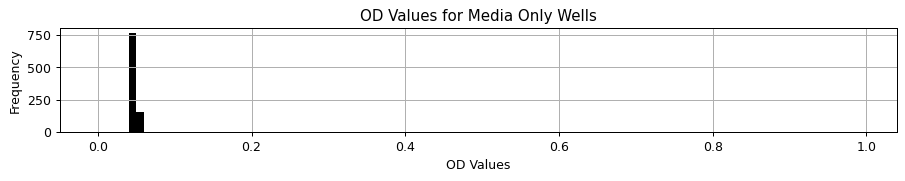

0.048


In [15]:
median_background_all_plates = plategig.static.calc_median_background_all_plates(
    df, df_plate_info, plot=True)
#I had to make these changes because there was a problem with the plate map info, confirm with Adam.
print(median_background_all_plates)

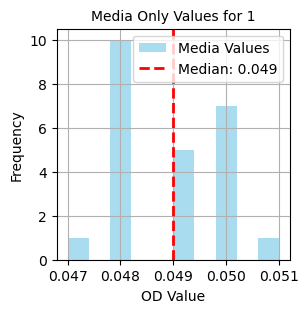

np.float64(0.049)

In [16]:
plategig.static.plot_single_plate_media_only_wells(df, df_plate_info, plate_id=1, column_name='OD')

Apply background correction for all plates

In [17]:
df_bc = df.copy()
df_bc['OD_final'] = df_bc['OD'] - median_background_all_plates

#### Evaluate growth metrics

In [18]:
df_bc

Plate_ID Well     OD  Row  Column  OD_final
0            1   A1  0.048    1       1     0.000
1            1   A2  0.051    1       2     0.003
2            1   A3  0.048    1       3     0.000
3            1   A4  0.050    1       4     0.002
4            1   A5  0.048    1       5     0.000
...        ...  ...    ...  ...     ...       ...
3547        37   H8  0.046    8       8    -0.002
3548        37   H9  0.045    8       9    -0.003
3549        37  H10  0.047    8      10    -0.001
3550        37  H11  0.045    8      11    -0.003
3551        37  H12  0.046    8      12    -0.002

[3552 rows x 6 columns]

In [22]:
df_analysis['Strain'].value_counts()

Strain
TEM-1                            327
NEB10B                           325
TEM-1-CML                        324
L21P-E104K-R164N-E240K-T265M     216
E104K-R164N-M182T-E240K          216
Q39K-E104K-R164N-E240K           216
Q39K-E104K-R164N-M182T-E240K     216
Q39K-E104K-R164S-E240K-T265M     216
E104K-R164N-E240K-T265M          216
L21P-E104K-R164N-M182T-E240K     216
TEM-1_MIC_range_changed           72
NEB10B_MIC_test_range_changed     36
NEB10B_MIC_range_changed          36
Name: count, dtype: int64

In [23]:
# Prep the analysis dataframe
df_analysis = pd.merge(df_plate_info, df_bc, on=['Plate_ID', 'Well'])
df_analysis = df_analysis[['Experiment','Strain', 'Culture', 'Replicate', 'Antibiotic',
                           'Dose', 'Plate_ID', 'Well', 'Row', 'Column',
                           'OD', 'OD_final']]
# Remove control wells
df_analysis = df_analysis[~df_analysis['Strain'].isin(['Media Only','Cells Only'])]
# Keep group names
df_analysis['Group'] = df_analysis.Strain
# Define each culture of as a separate strain
# df_analysis['Strain'] = df_analysis.Strain + df_analysis.Culture.astype(int).astype(str)
df_analysis


Experiment     Strain  Culture  Replicate  Antibiotic          Dose  \
12             1     NEB10B      1.0        1.0  Ampicillin  30000.000000   
13             1     NEB10B      1.0        1.0  Ampicillin  10000.000000   
14             1     NEB10B      1.0        1.0  Ampicillin   3333.333330   
15             1     NEB10B      1.0        1.0  Ampicillin   1111.111110   
16             1     NEB10B      1.0        1.0  Ampicillin    370.370370   
...          ...        ...      ...        ...         ...           ...   
3499           1  TEM-1-CML      1.0        3.0   Ertapenem      0.014632   
3500           1  TEM-1-CML      1.0        3.0   Ertapenem      0.004877   
3501           1  TEM-1-CML      1.0        3.0   Ertapenem      0.001626   
3502           1  TEM-1-CML      1.0        3.0   Ertapenem      0.000542   
3503           1  TEM-1-CML      1.0        3.0   Ertapenem      0.000000   

      Plate_ID Well  Row  Column     OD  OD_final      Group  
12           1   B1    2       1  0.042    -0.006     NEB10B  
13           1   B2    2       2  0.043    -0.005     NEB10B  
14           1   B3    2       3  0.043    -0.005     NEB10B  
15           1   B4    2       4  0.043    -0.005     NEB10B  
16           1   B5    2       5  0.042    -0.006     NEB10B  
...        ...  ...  ...     ...    ...       ...        ...  
3499        37   D8    4       8  0.353     0.305  TEM-1-CML  
3500        37   D9    4       9  0.384     0.336  TEM-1-CML  
3501        37  D10    4      10  0.320     0.272  TEM-1-CML  
3502        37  D11    4      11  0.330     0.282  TEM-1-CML  
3503        37  D12    4      12  0.784     0.736  TEM-1-CML  

[2632 rows x 13 columns]

In [24]:
unique_groups = df_analysis['Group'].unique().tolist()
print(unique_groups)

['NEB10B', 'NEB10B_MIC_test_range_changed', 'TEM-1', 'TEM-1_MIC_range_changed', 'TEM-1-CML', 'E104K-R164N-M182T-E240K', 'L21P-E104K-R164N-E240K-T265M', 'Q39K-E104K-R164S-E240K-T265M', 'E104K-R164N-E240K-T265M', 'Q39K-E104K-R164N-E240K', 'Q39K-E104K-R164N-M182T-E240K', 'L21P-E104K-R164N-M182T-E240K', 'NEB10B_MIC_range_changed']


In [25]:
### Double check
unique_columns = df_analysis.columns.tolist()

# Print the list of unique columns
print(unique_columns)

#
unique_values = df_analysis['Strain'].unique()

# Print the unique values
print(unique_values)

['Experiment', 'Strain', 'Culture', 'Replicate', 'Antibiotic', 'Dose', 'Plate_ID', 'Well', 'Row', 'Column', 'OD', 'OD_final', 'Group']
['NEB10B' 'NEB10B_MIC_test_range_changed' 'TEM-1'
 'TEM-1_MIC_range_changed' 'TEM-1-CML' 'E104K-R164N-M182T-E240K'
 'L21P-E104K-R164N-E240K-T265M' 'Q39K-E104K-R164S-E240K-T265M'
 'E104K-R164N-E240K-T265M' 'Q39K-E104K-R164N-E240K'
 'Q39K-E104K-R164N-M182T-E240K' 'L21P-E104K-R164N-M182T-E240K'
 'NEB10B_MIC_range_changed']


In [28]:
antibiotics = df_analysis['Antibiotic'].dropna().unique()
antibiotics

array(['Ampicillin', 'Aztreonam', 'Cefotaxime', 'Ceftriaxone',
       'Ceftazidime', 'Cefepime', 'Imipenem', 'Meropenem', 'Ertapenem'],
      dtype=object)

In [29]:
df_analysis.query("Antibiotic == 'Cefotaxime' & Strain == 'NEB10B'")

Experiment  Strain  Culture  Replicate  Antibiotic       Dose  Plate_ID  \
972            1  NEB10B      1.0        1.0  Cefotaxime  32.000000        11   
973            1  NEB10B      1.0        1.0  Cefotaxime  10.666667        11   
974            1  NEB10B      1.0        1.0  Cefotaxime   3.555556        11   
975            1  NEB10B      1.0        1.0  Cefotaxime   1.185185        11   
976            1  NEB10B      1.0        1.0  Cefotaxime   0.395062        11   
977            1  NEB10B      1.0        1.0  Cefotaxime   0.131687        11   
978            1  NEB10B      1.0        1.0  Cefotaxime   0.043896        11   
979            1  NEB10B      1.0        1.0  Cefotaxime   0.014632        11   
980            1  NEB10B      1.0        1.0  Cefotaxime   0.004877        11   
981            1  NEB10B      1.0        1.0  Cefotaxime   0.001626        11   
982            1  NEB10B      1.0        1.0  Cefotaxime   0.000542        11   
983            1  NEB10B      1.0        1.0  Cefotaxime   0.000000        11   
984            1  NEB10B      1.0        2.0  Cefotaxime  32.000000        11   
985            1  NEB10B      1.0        2.0  Cefotaxime  10.666667        11   
986            1  NEB10B      1.0        2.0  Cefotaxime   3.555556        11   
987            1  NEB10B      1.0        2.0  Cefotaxime   1.185185        11   
988            1  NEB10B      1.0        2.0  Cefotaxime   0.395062        11   
989            1  NEB10B      1.0        2.0  Cefotaxime   0.131687        11   
990            1  NEB10B      1.0        2.0  Cefotaxime   0.043896        11   
991            1  NEB10B      1.0        2.0  Cefotaxime   0.014632        11   
992            1  NEB10B      1.0        2.0  Cefotaxime   0.004877        11   
993            1  NEB10B      1.0        2.0  Cefotaxime   0.001626        11   
994            1  NEB10B      1.0        2.0  Cefotaxime   0.000542        11   
995            1  NEB10B      1.0        2.0  Cefotaxime   0.000000        11   
996            1  NEB10B      1.0        3.0  Cefotaxime  32.000000        11   
997            1  NEB10B      1.0        3.0  Cefotaxime  10.666667        11   
998            1  NEB10B      1.0        3.0  Cefotaxime   3.555556        11   
999            1  NEB10B      1.0        3.0  Cefotaxime   1.185185        11   
1000           1  NEB10B      1.0        3.0  Cefotaxime   0.395062        11   
1001           1  NEB10B      1.0        3.0  Cefotaxime   0.131687        11   
1002           1  NEB10B      1.0        3.0  Cefotaxime   0.043896        11   
1003           1  NEB10B      1.0        3.0  Cefotaxime   0.014632        11   
1004           1  NEB10B      1.0        3.0  Cefotaxime   0.004877        11   
1005           1  NEB10B      1.0        3.0  Cefotaxime   0.001626        11   
1006           1  NEB10B      1.0        3.0  Cefotaxime   0.000542        11   
1007           1  NEB10B      1.0        3.0  Cefotaxime   0.000000        11   

     Well  Row  Column     OD  OD_final   Group  
972    B1    2       1  0.045    -0.003  NEB10B  
973    B2    2       2  0.045    -0.003  NEB10B  
974    B3    2       3  0.044    -0.004  NEB10B  
975    B4    2       4  0.044    -0.004  NEB10B  
976    B5    2       5  0.043    -0.005  NEB10B  
977    B6    2       6  0.043    -0.005  NEB10B  
978    B7    2       7  0.237     0.189  NEB10B  
979    B8    2       8  0.353     0.305  NEB10B  
980    B9    2       9  0.428     0.380  NEB10B  
981   B10    2      10  0.485     0.437  NEB10B  
982   B11    2      11  0.501     0.453  NEB10B  
983   B12    2      12  0.488     0.440  NEB10B  
984    C1    3       1  0.044    -0.004  NEB10B  
985    C2    3       2  0.043    -0.005  NEB10B  
986    C3    3       3  0.048     0.000  NEB10B  
987    C4    3       4  0.045    -0.003  NEB10B  
988    C5    3       5  0.045    -0.003  NEB10B  
989    C6    3       6  0.043    -0.005  NEB10B  
990    C7    3       7  0.226     0.178  NEB10B  
991    C

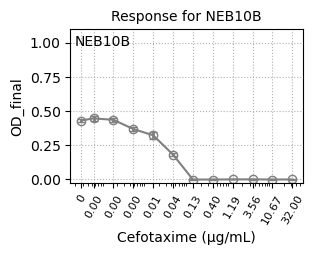

In [32]:

# Adjust the figure size as needed
fig, ax = plt.subplots(figsize=(3, 2))
plategig.static.plot_dose_response_curve_errorbar(df_analysis, 'NEB10B', 'Cefotaxime', strain_colors={'P1':'black'}, ax=ax)

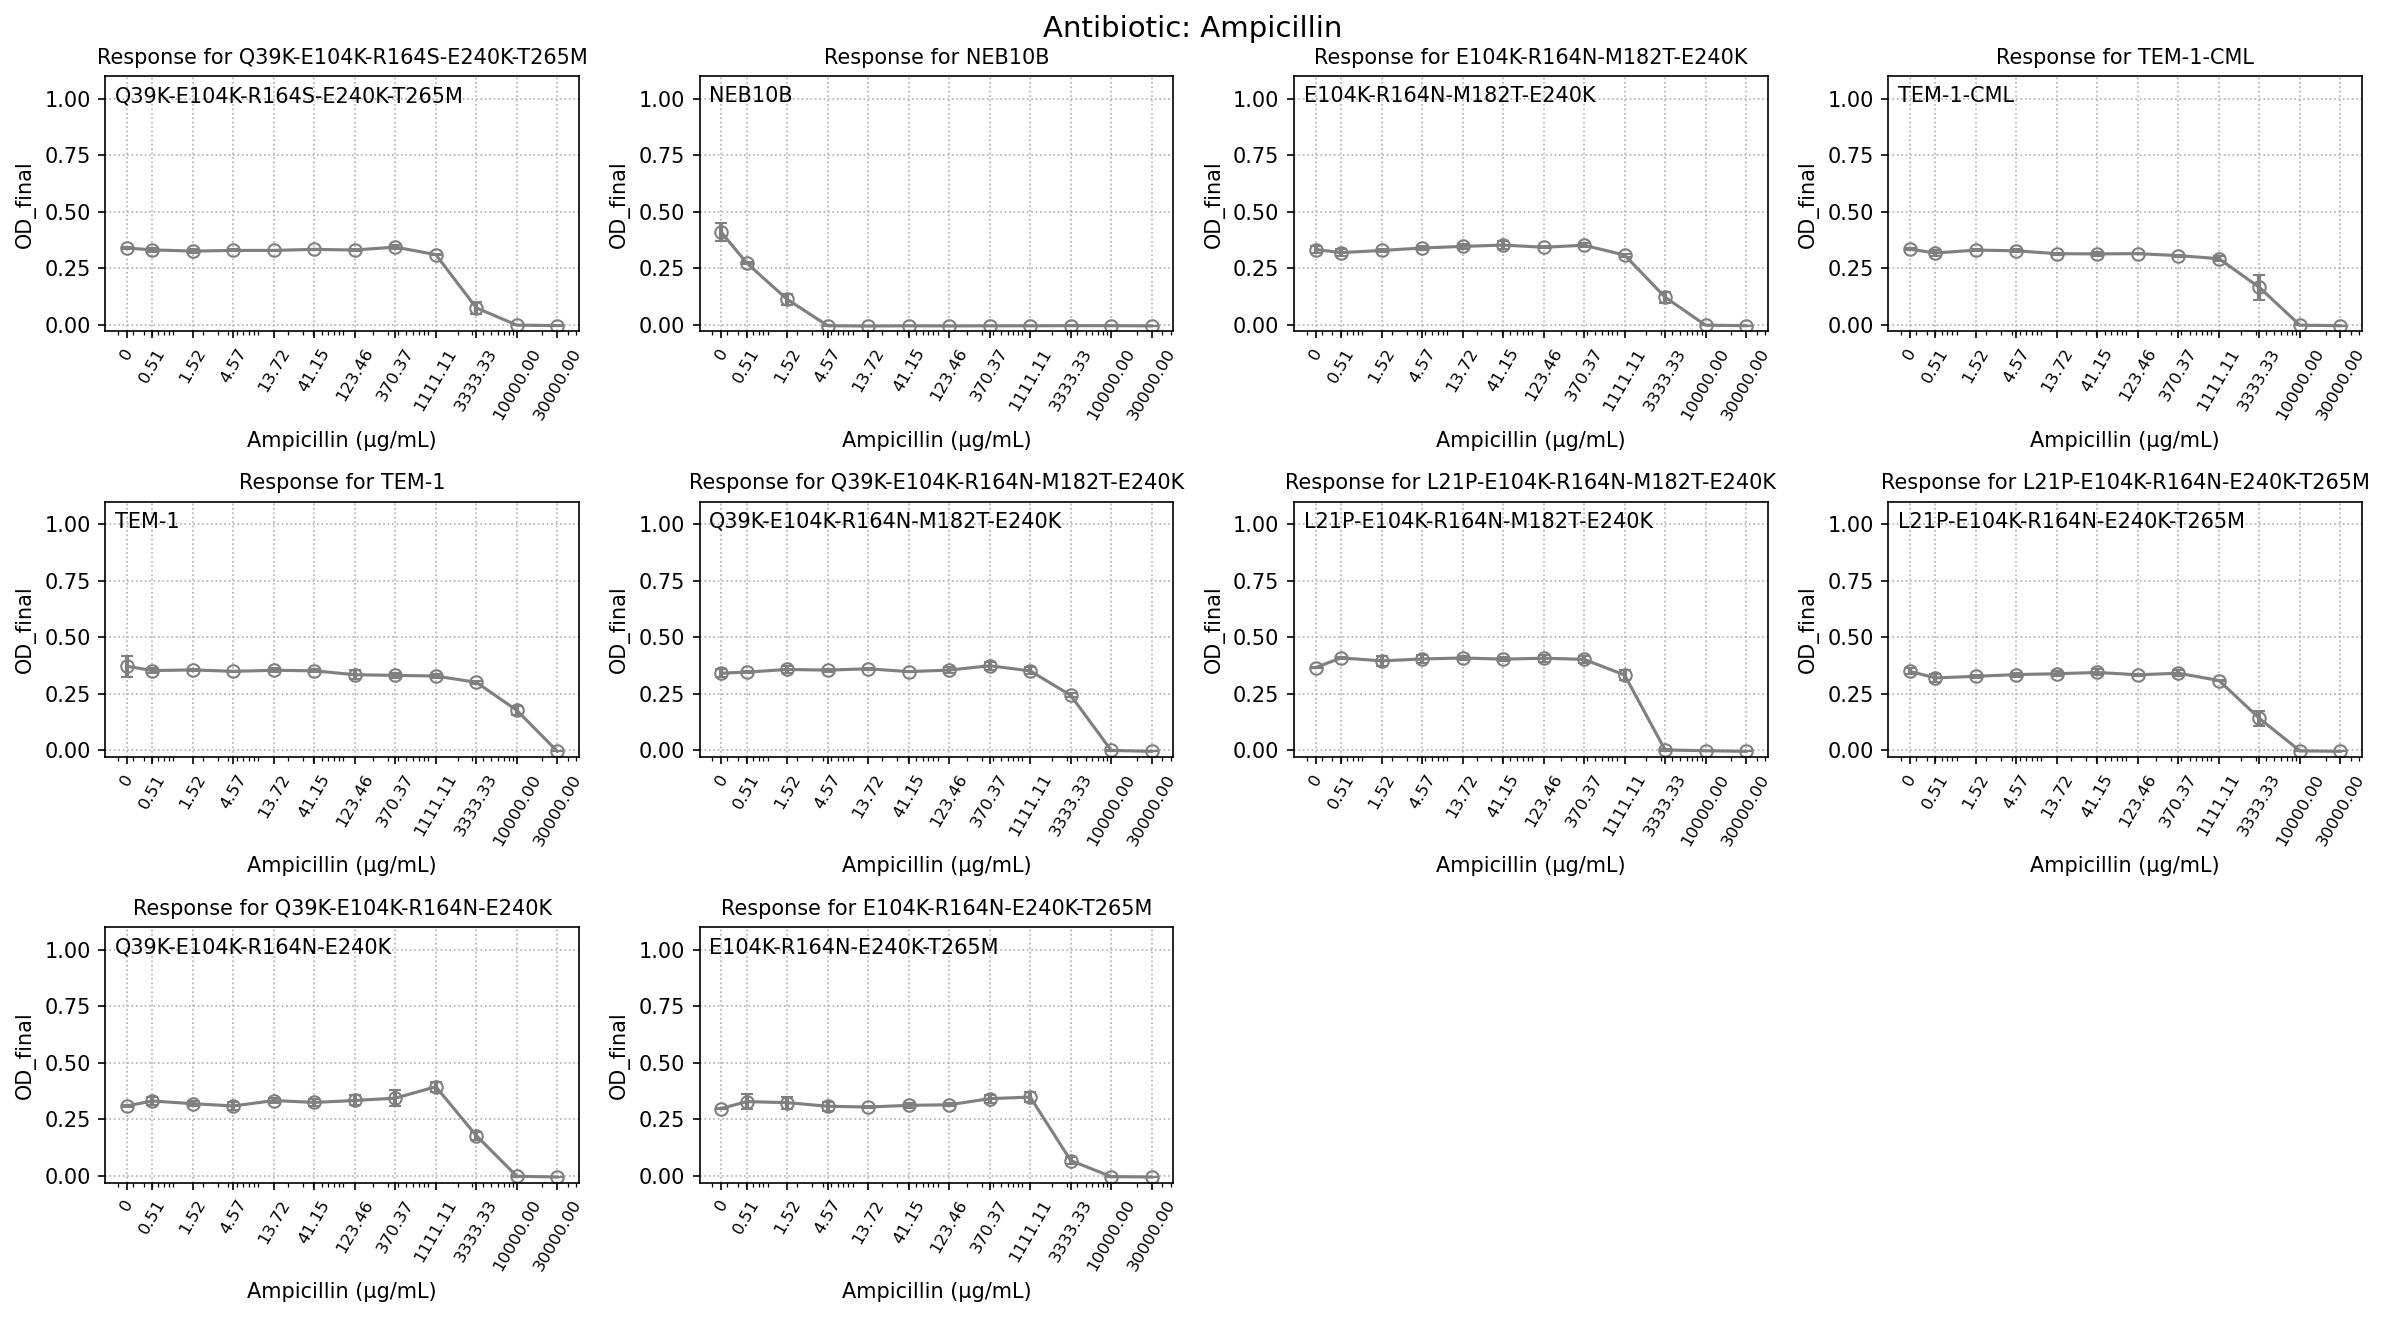

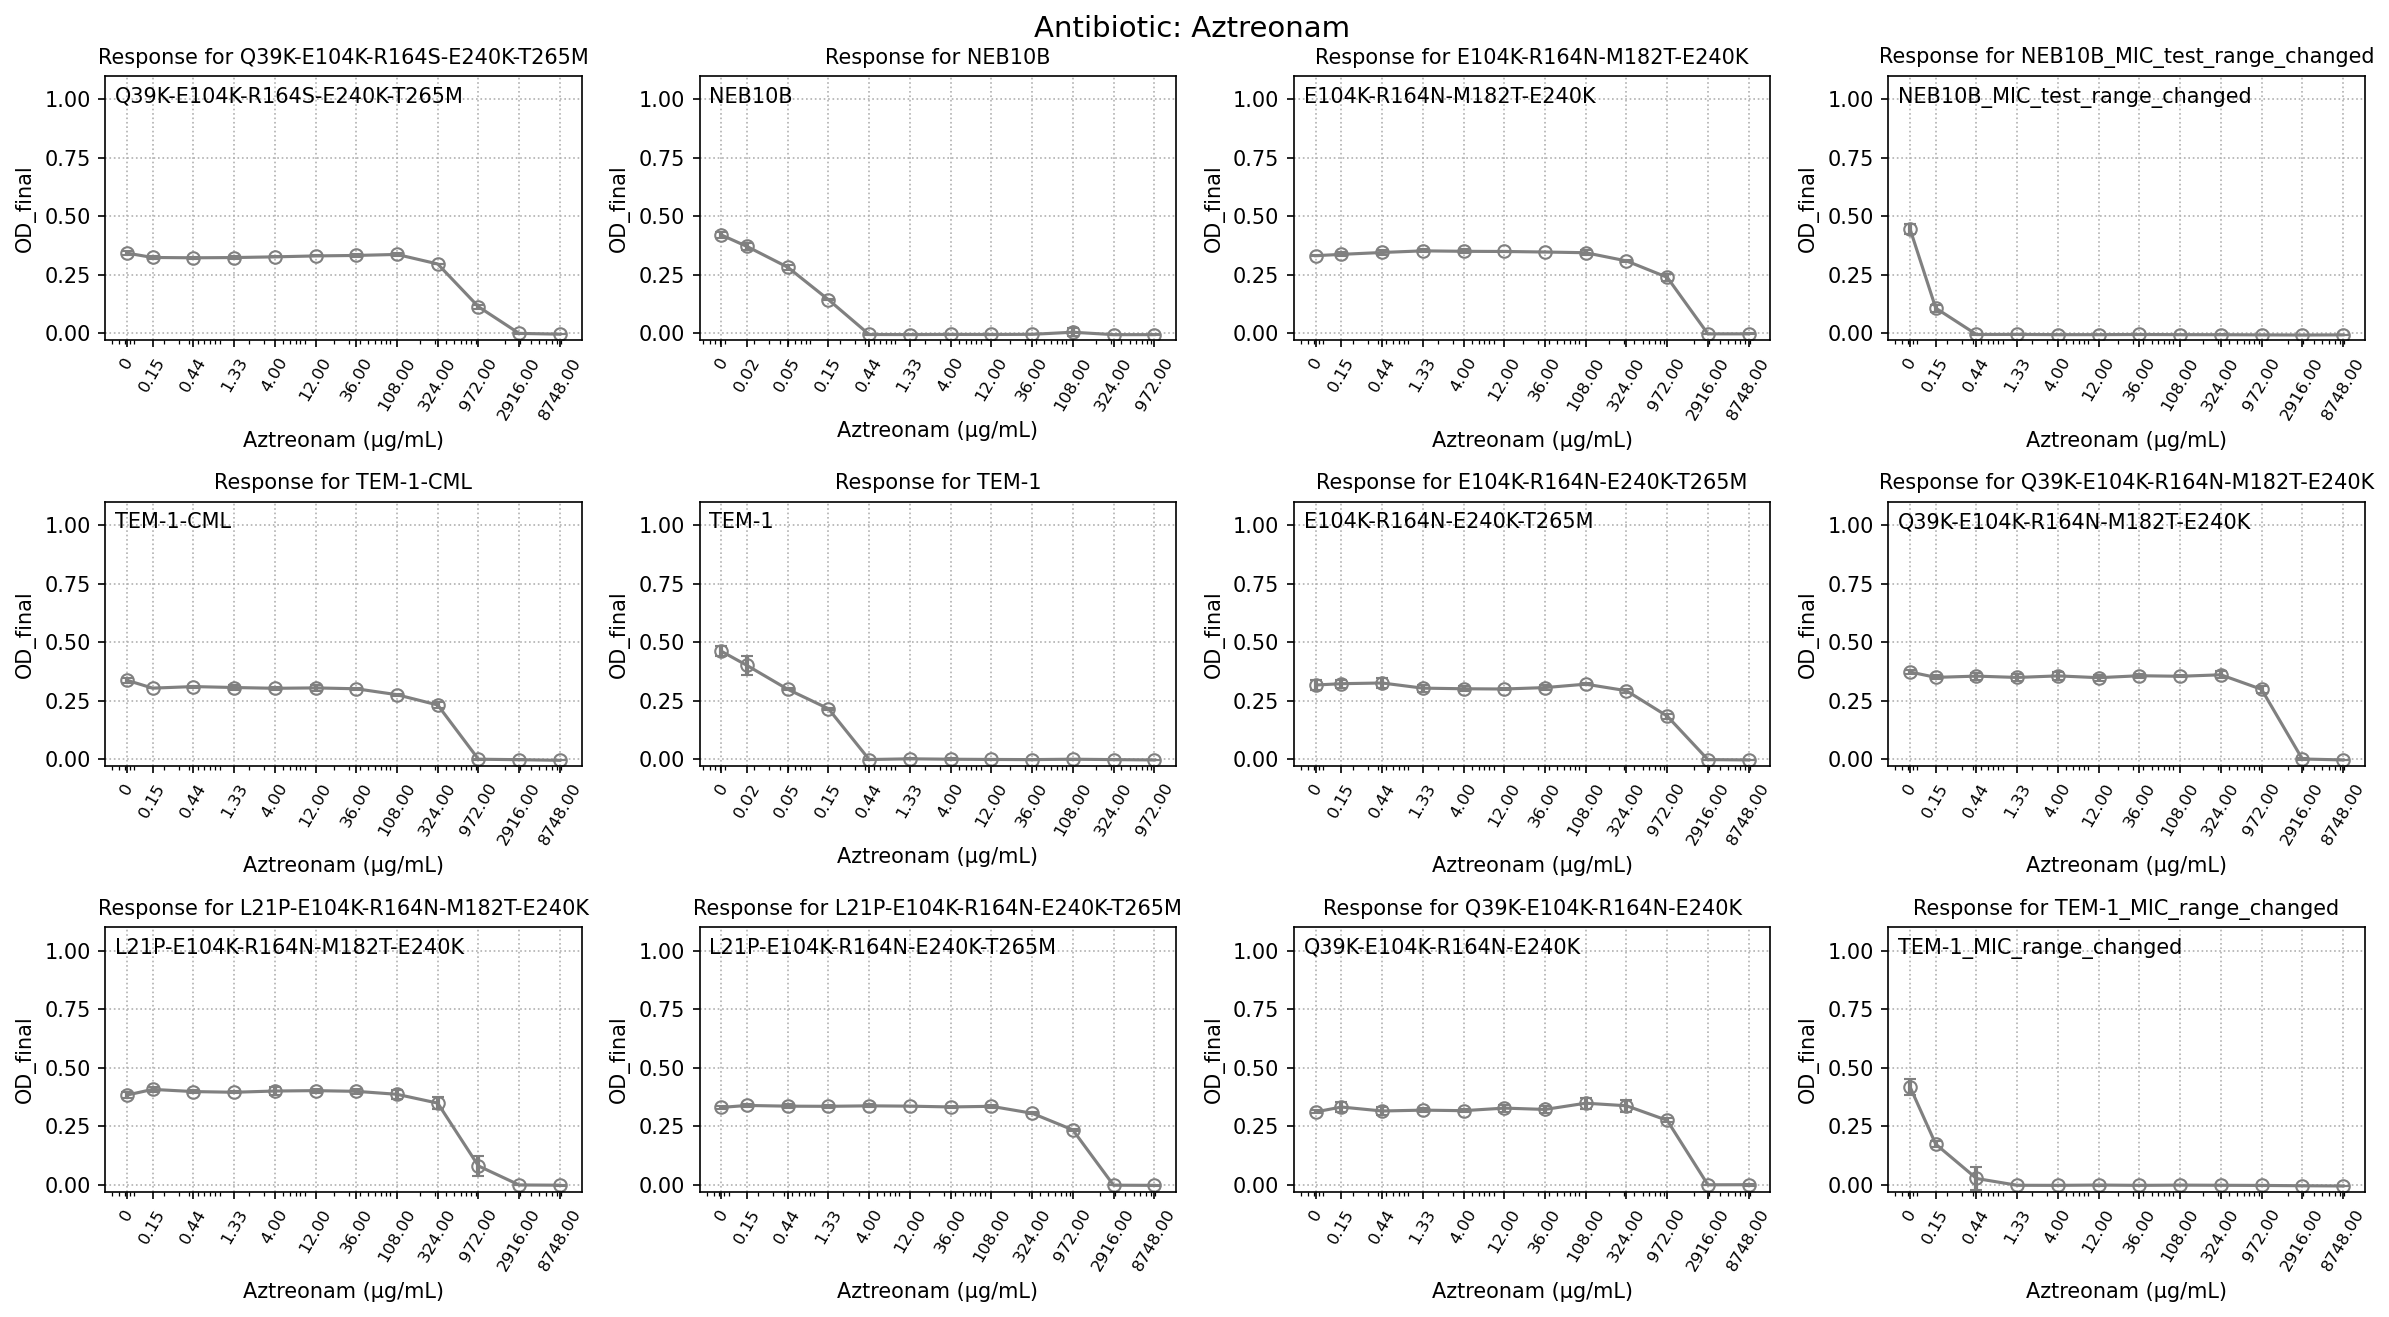

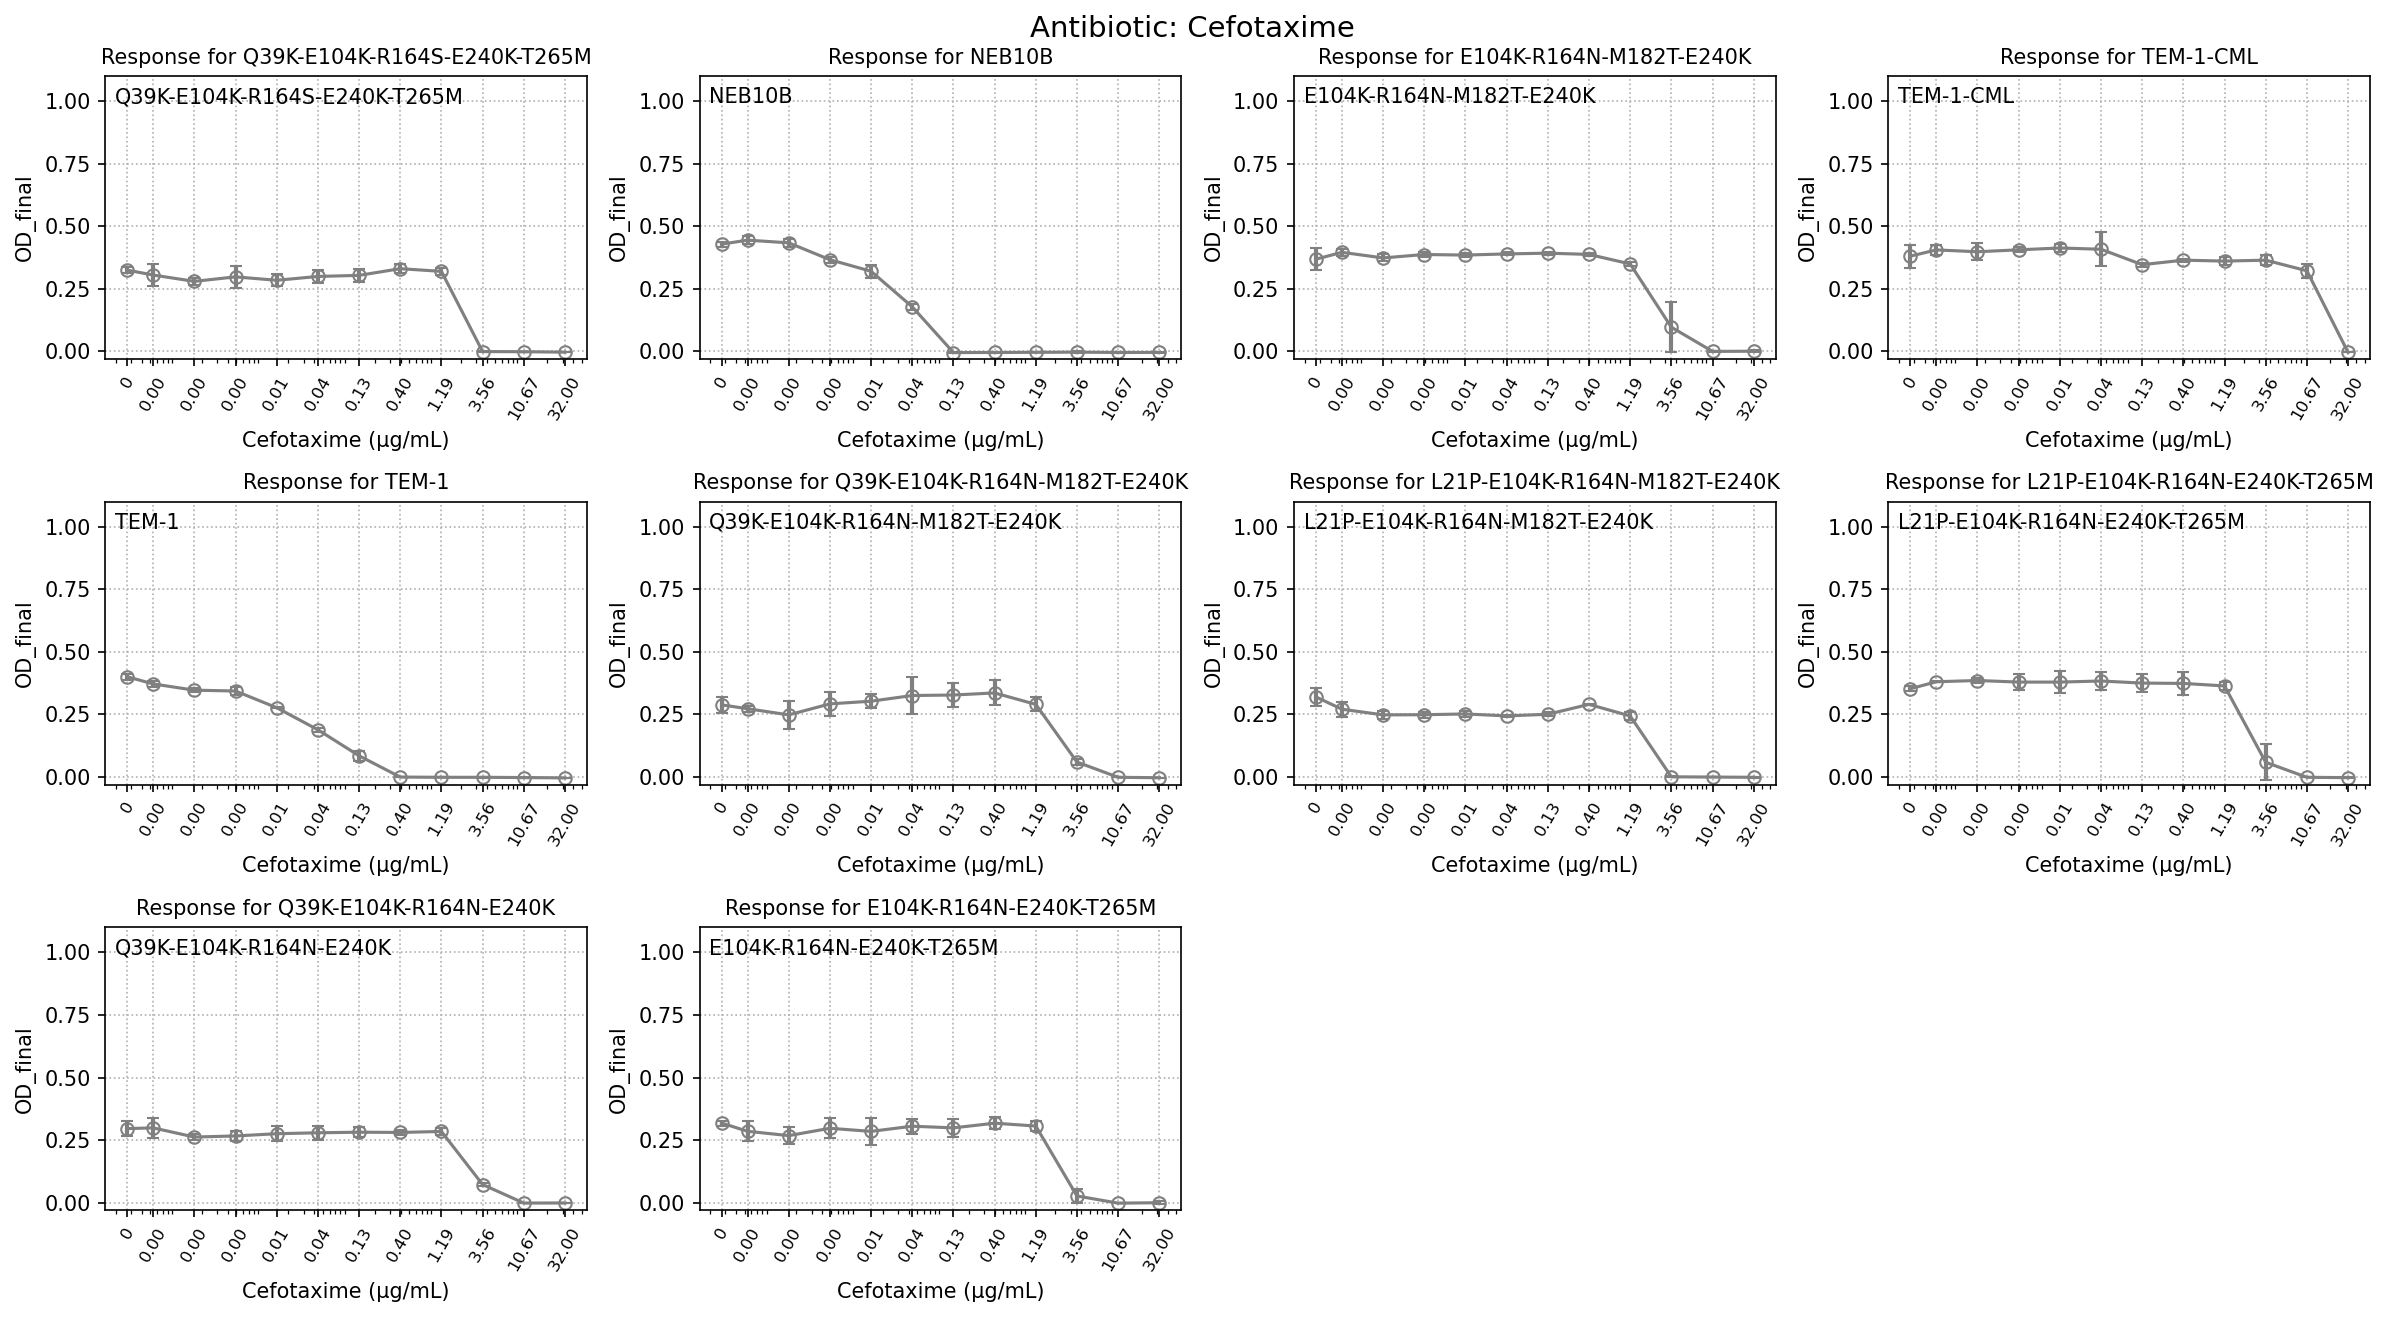

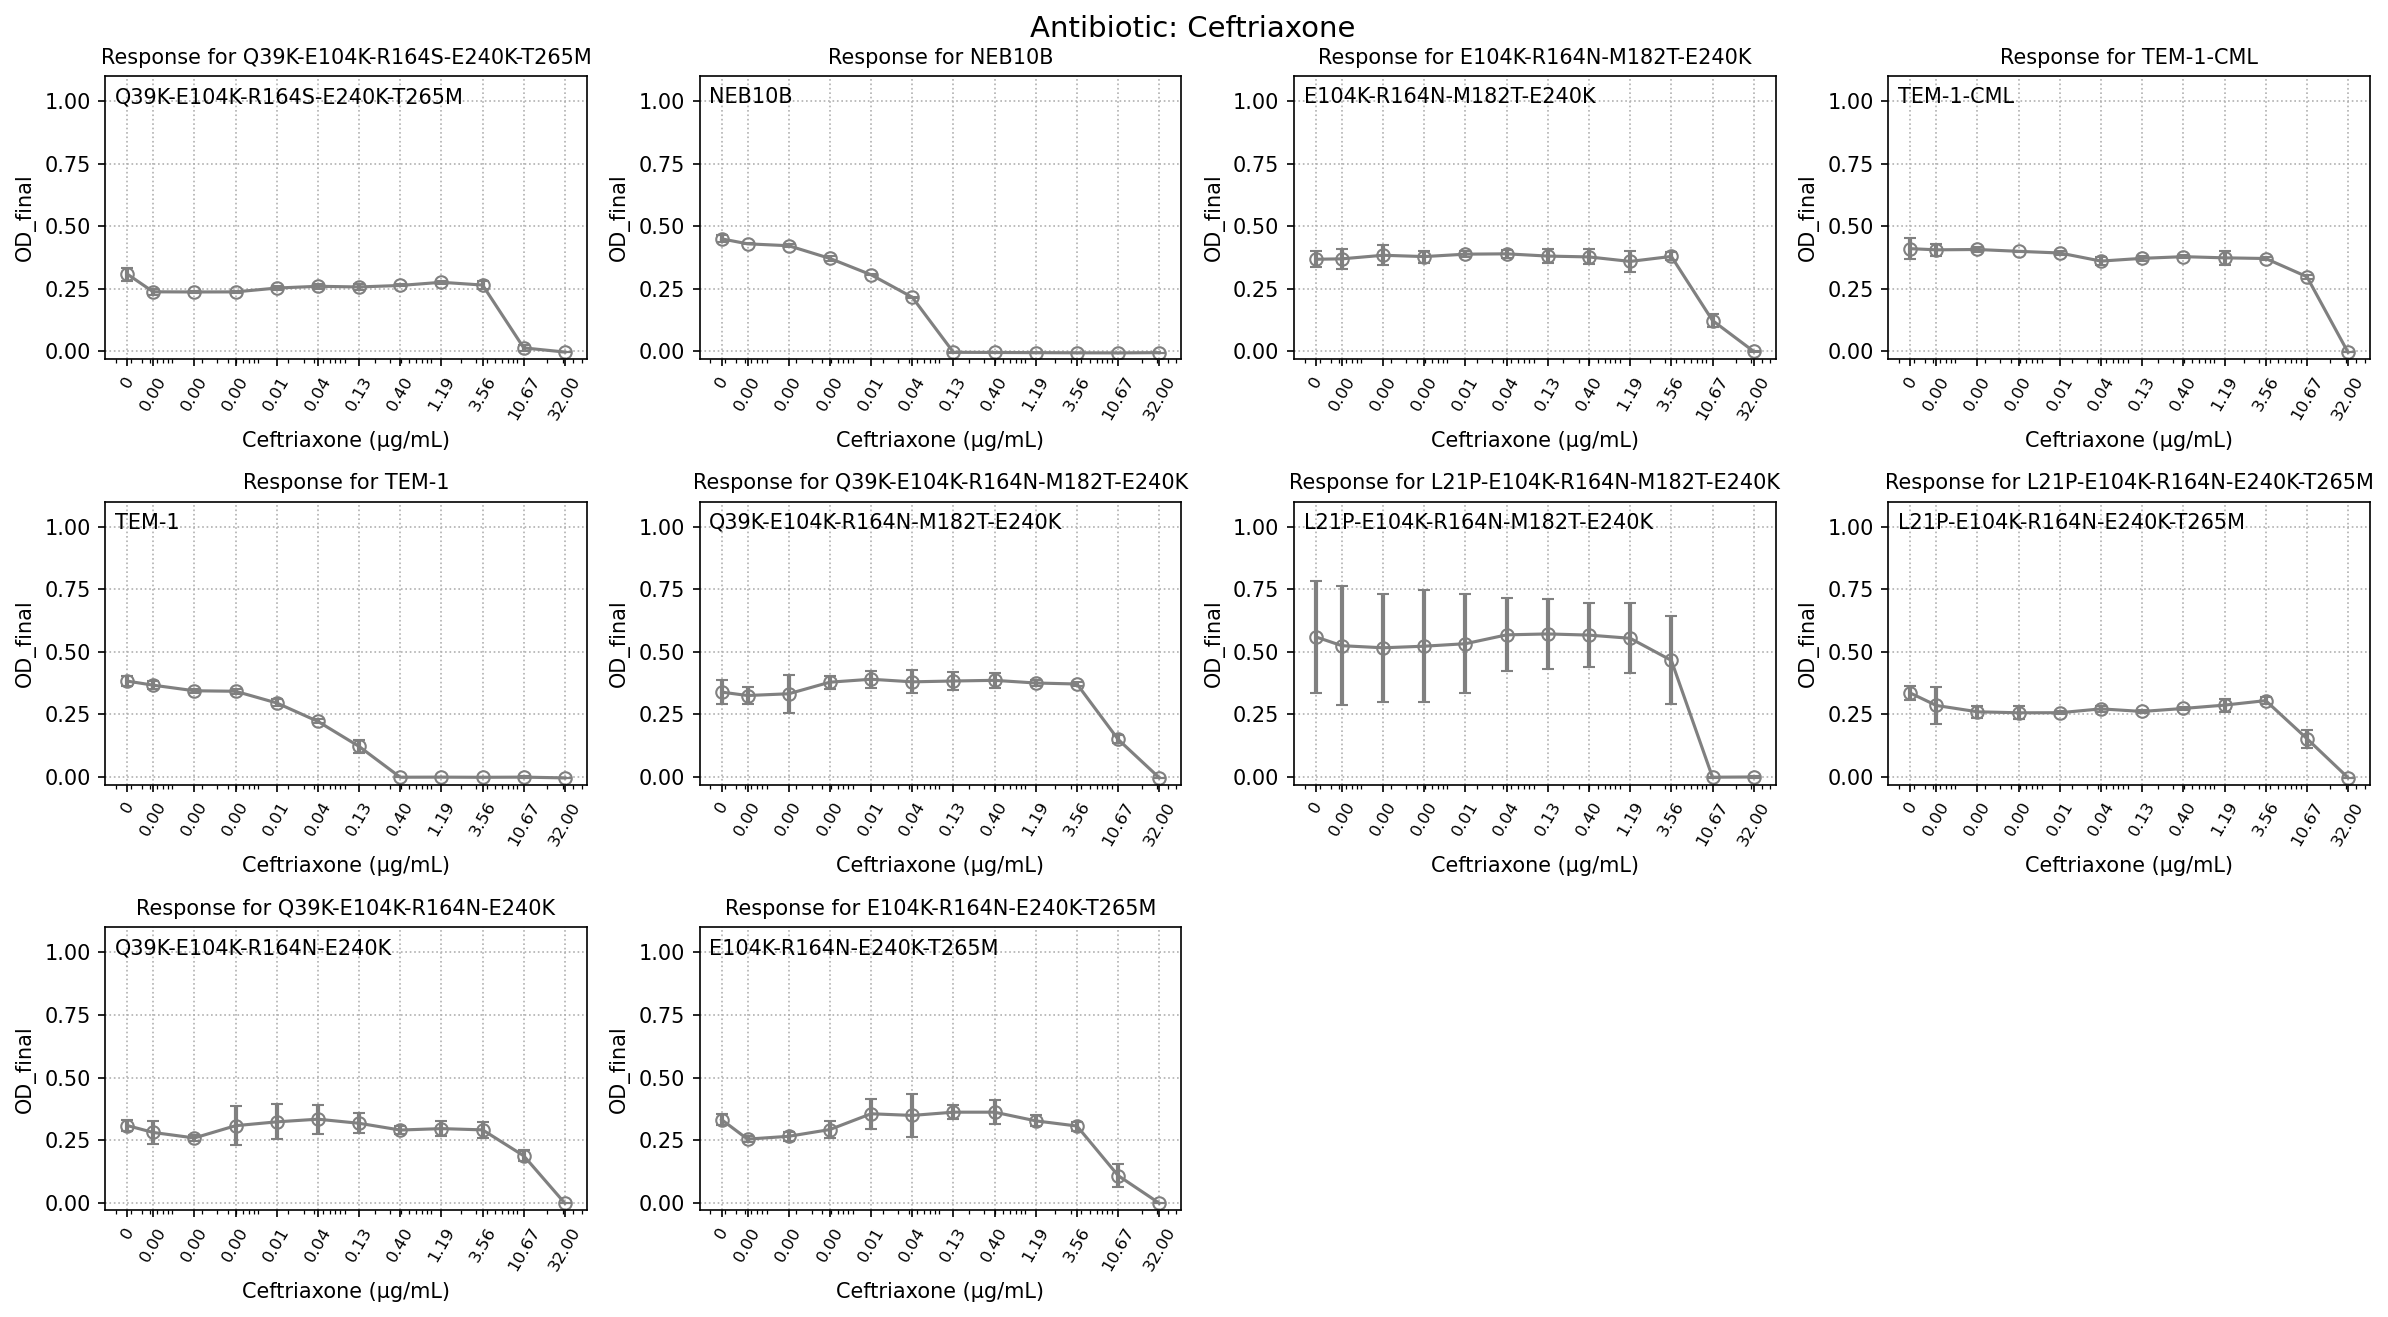

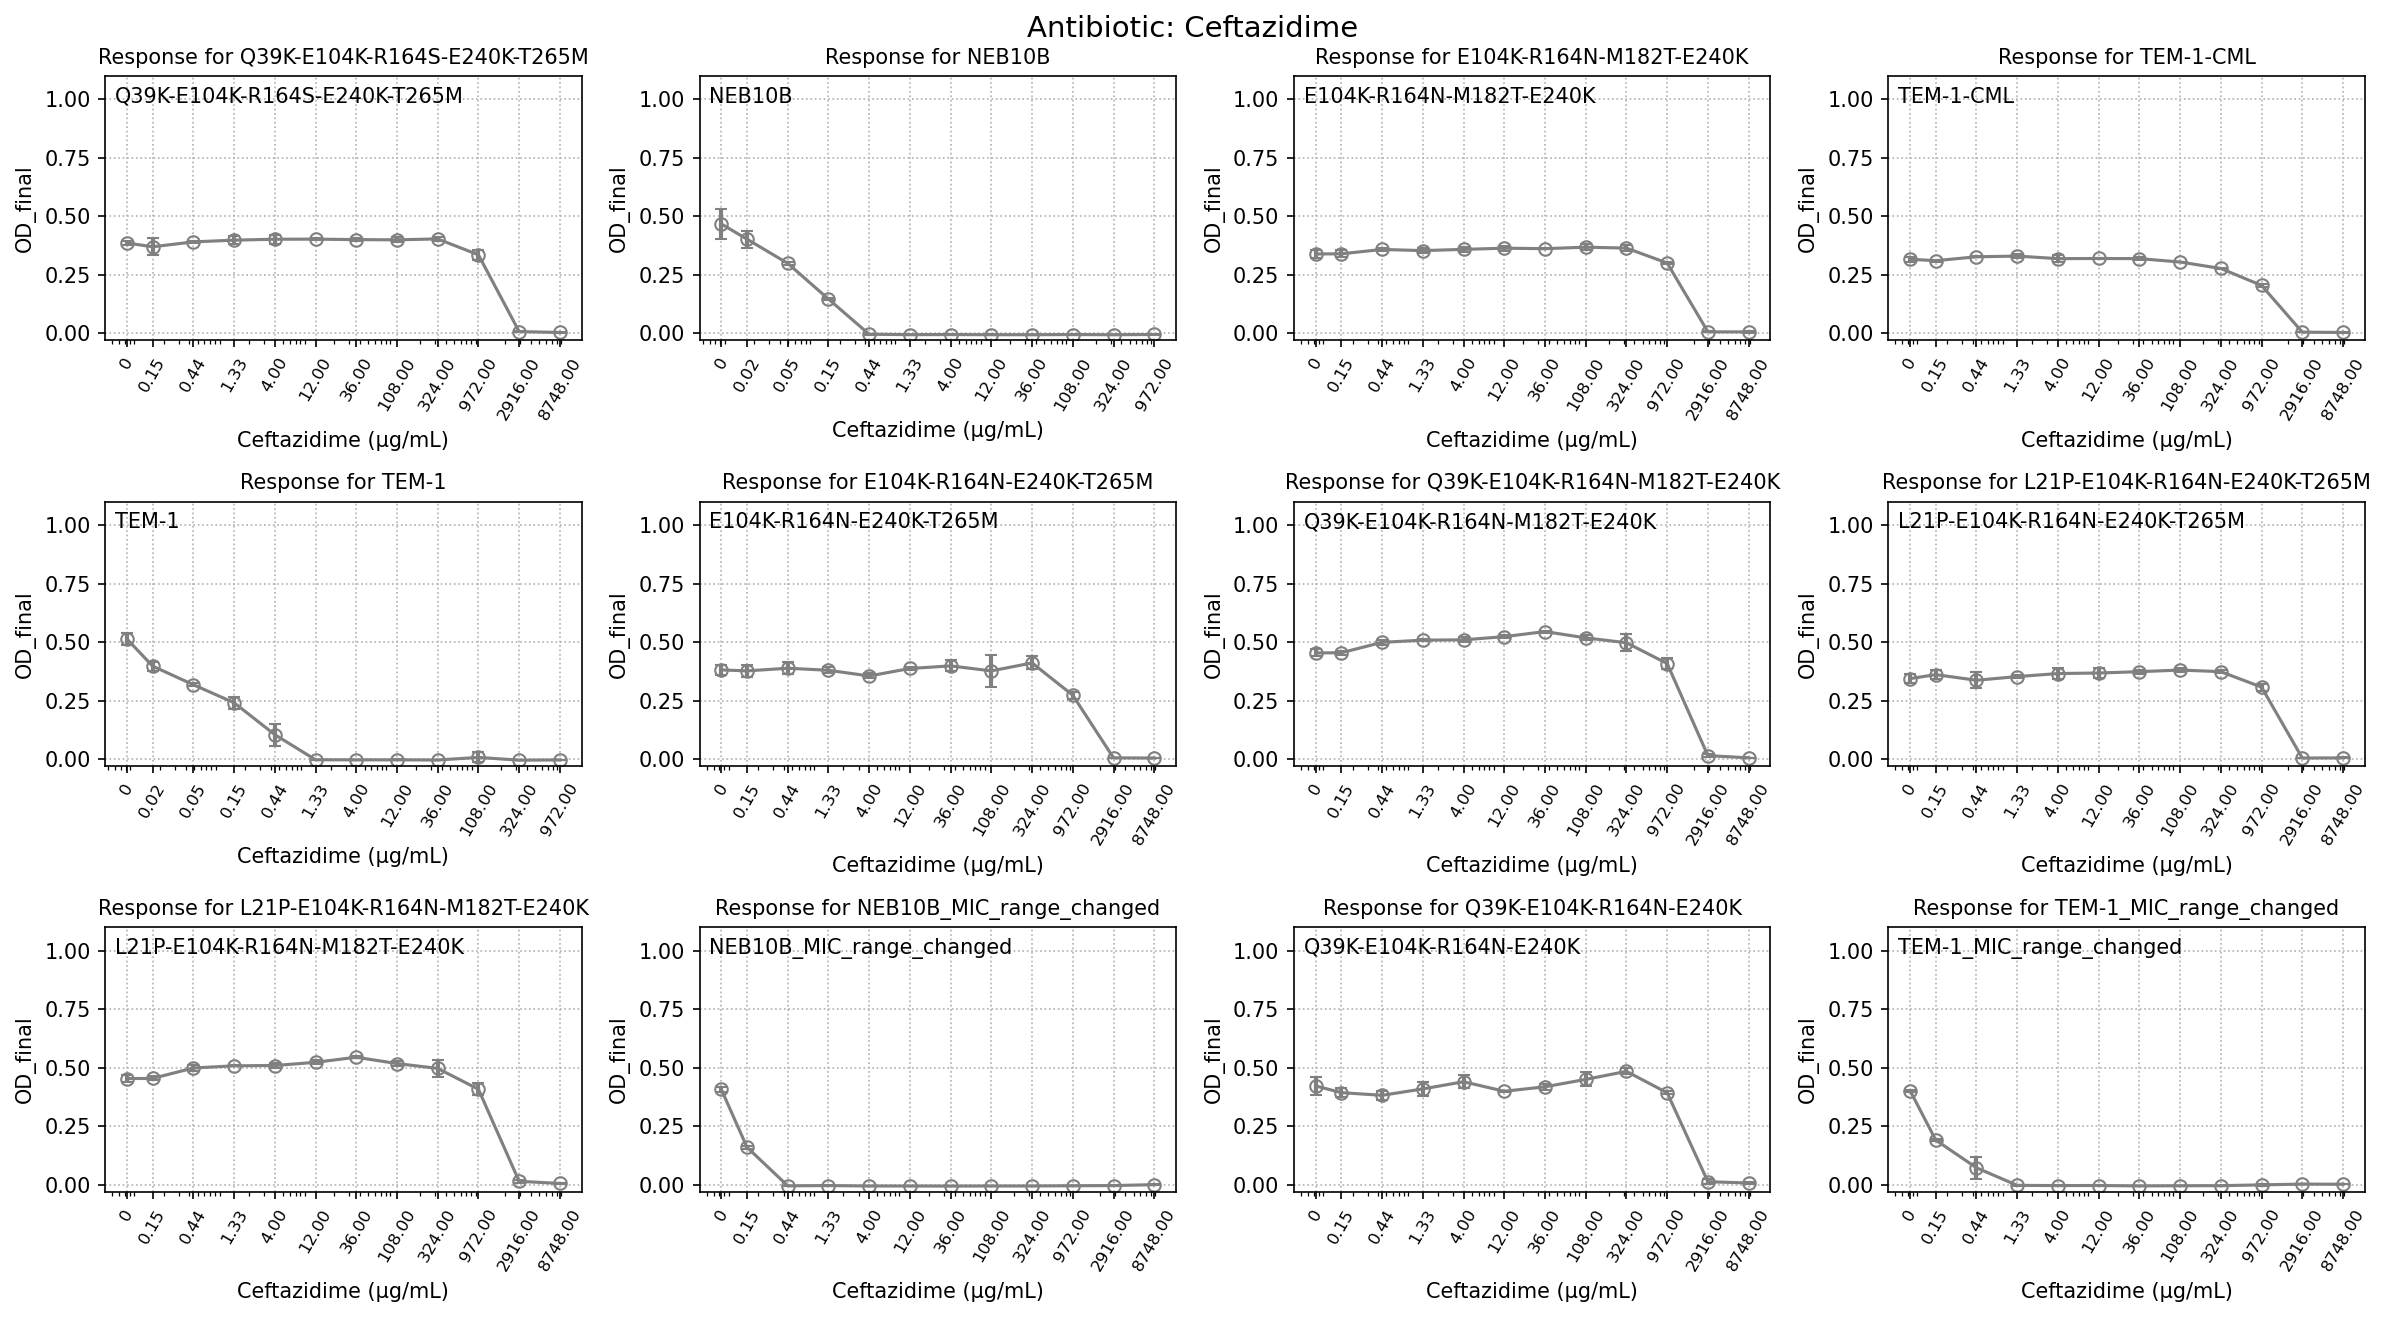

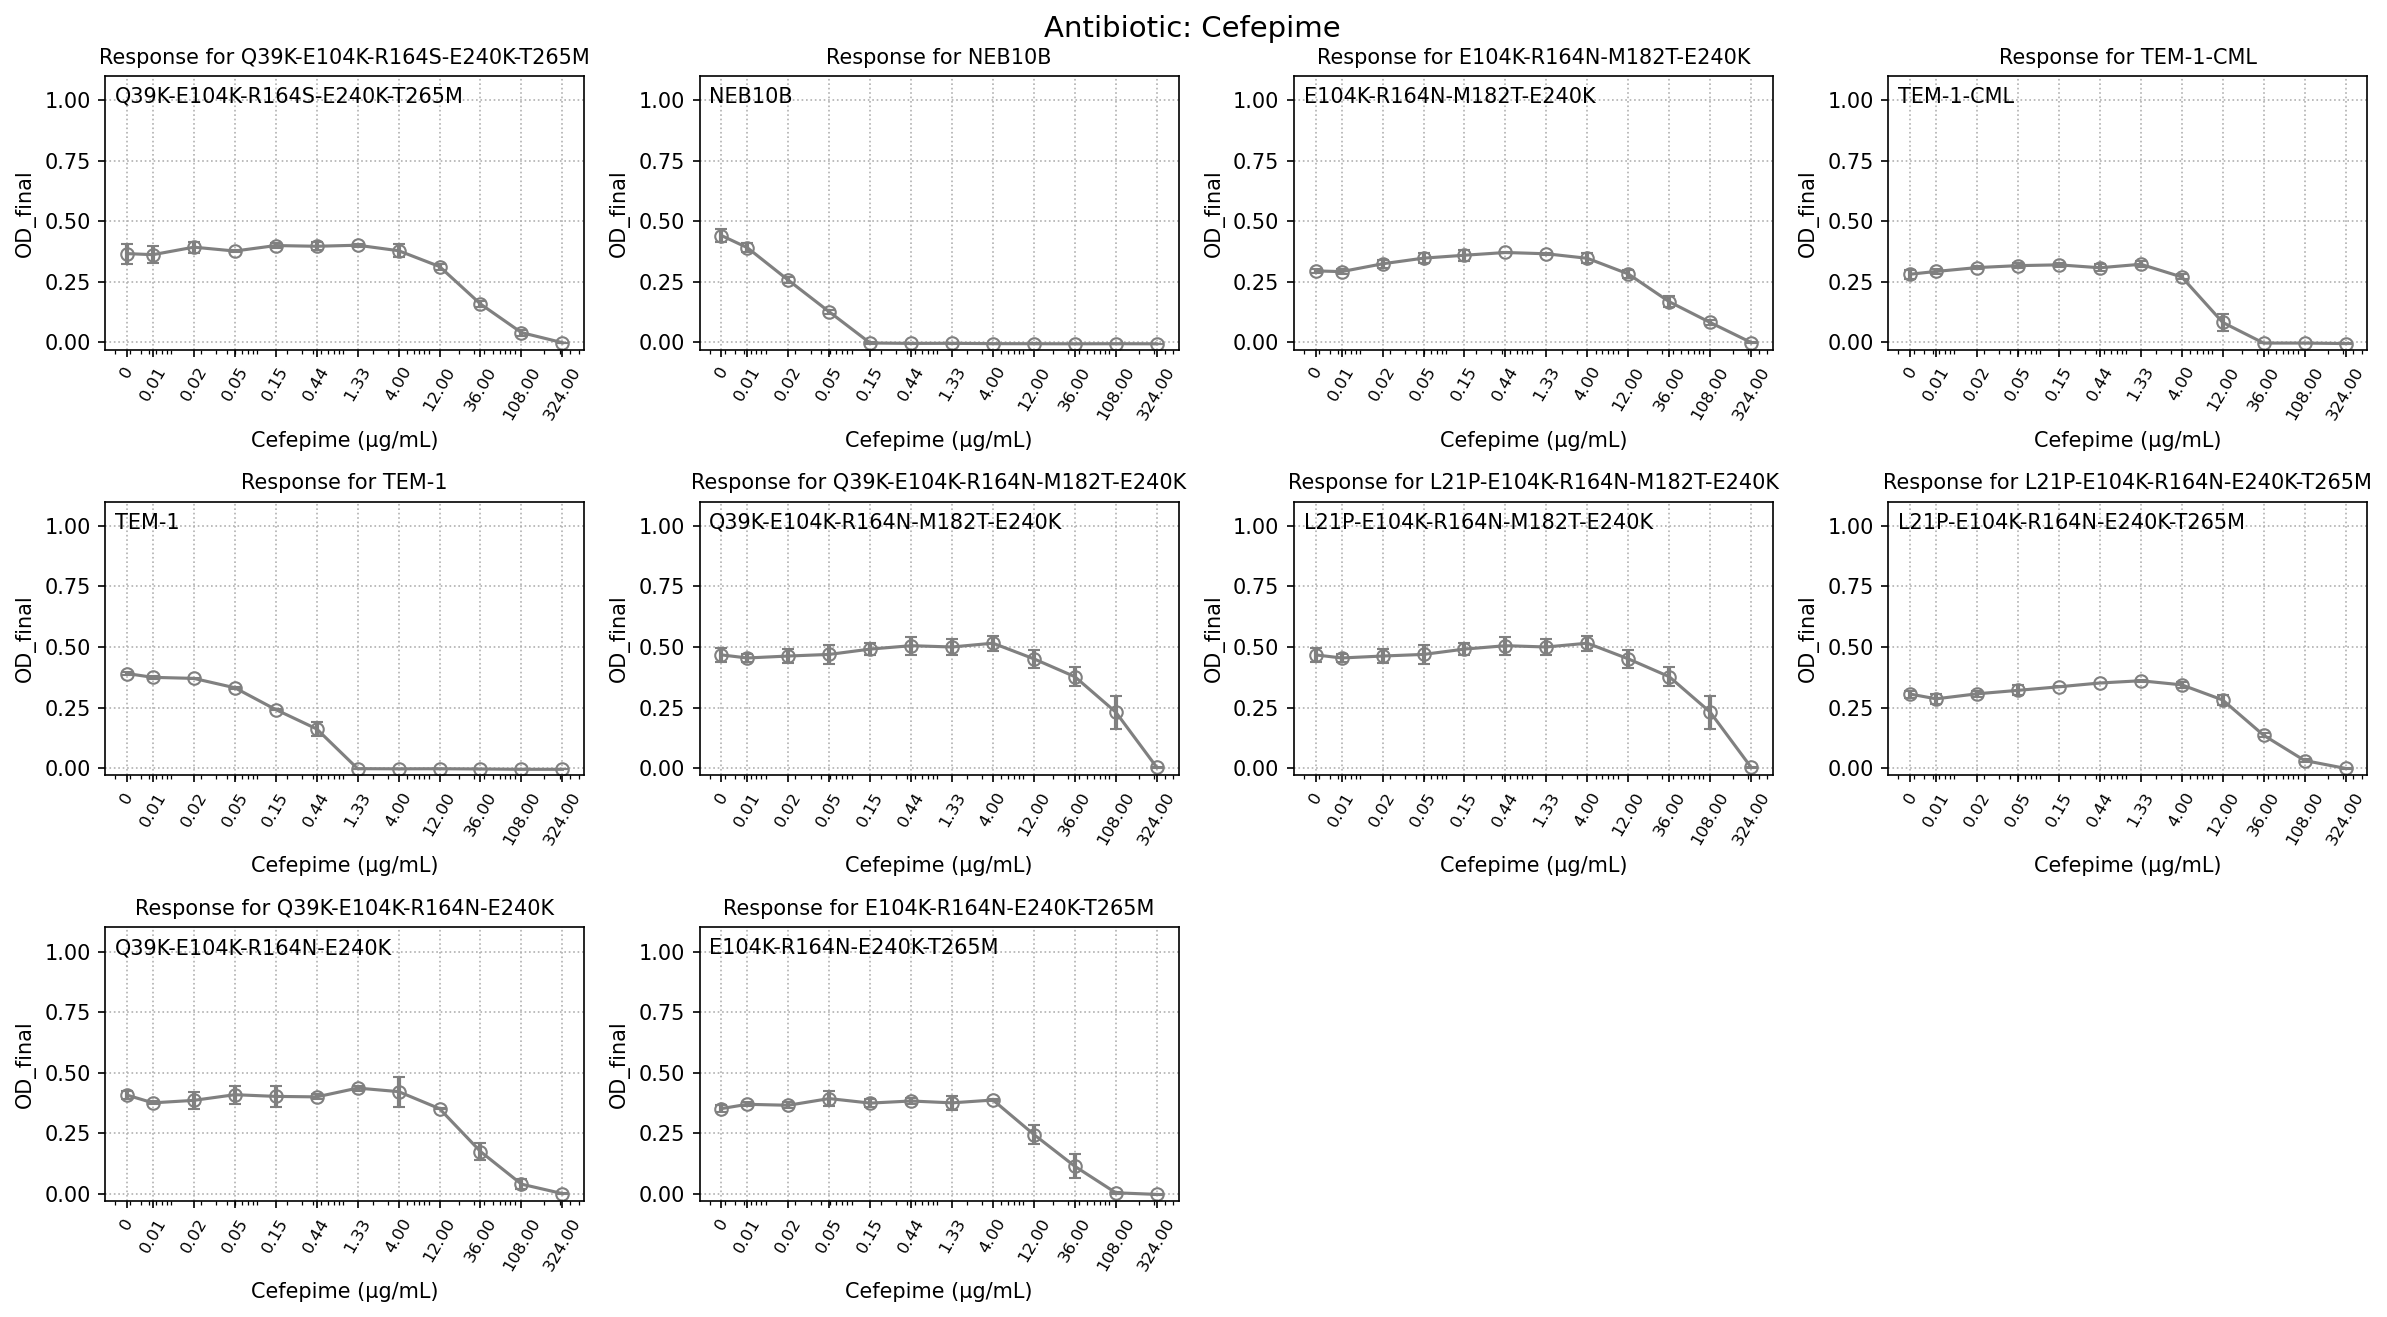

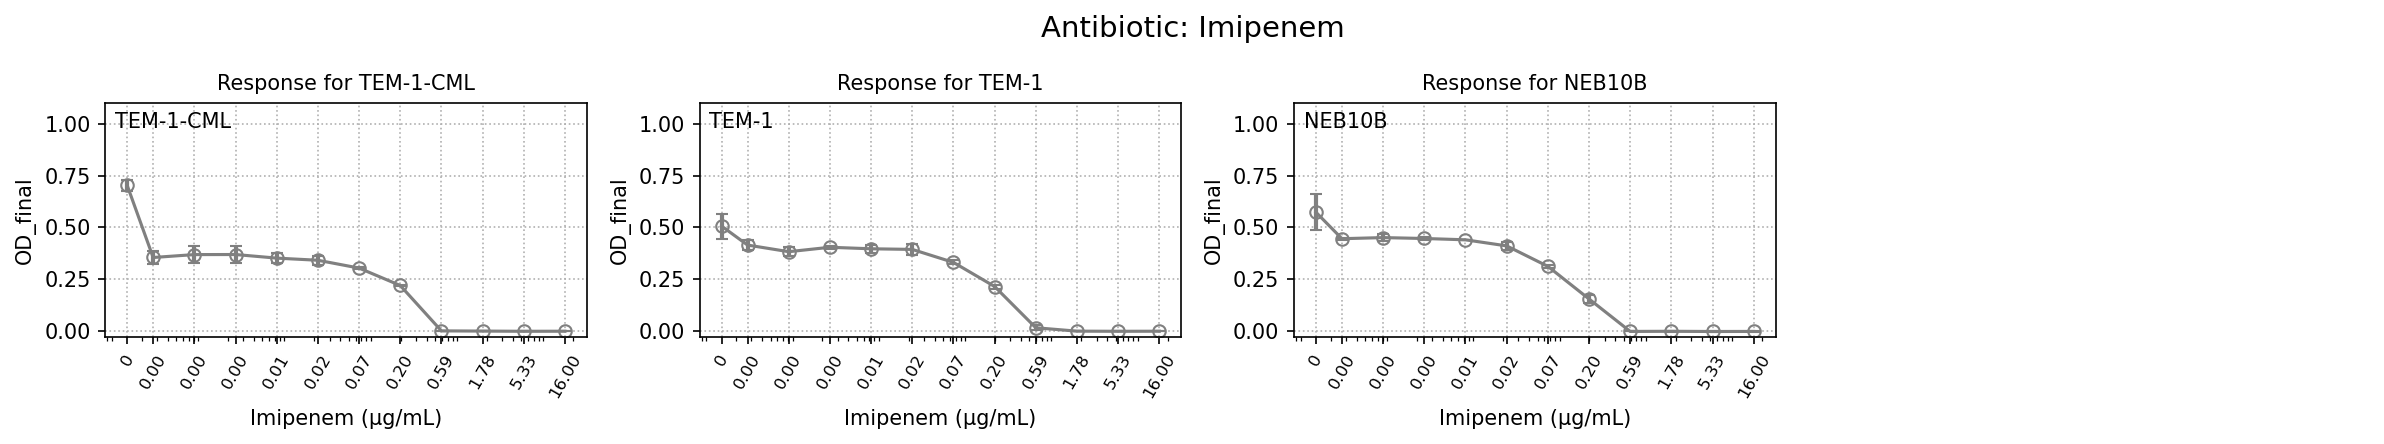

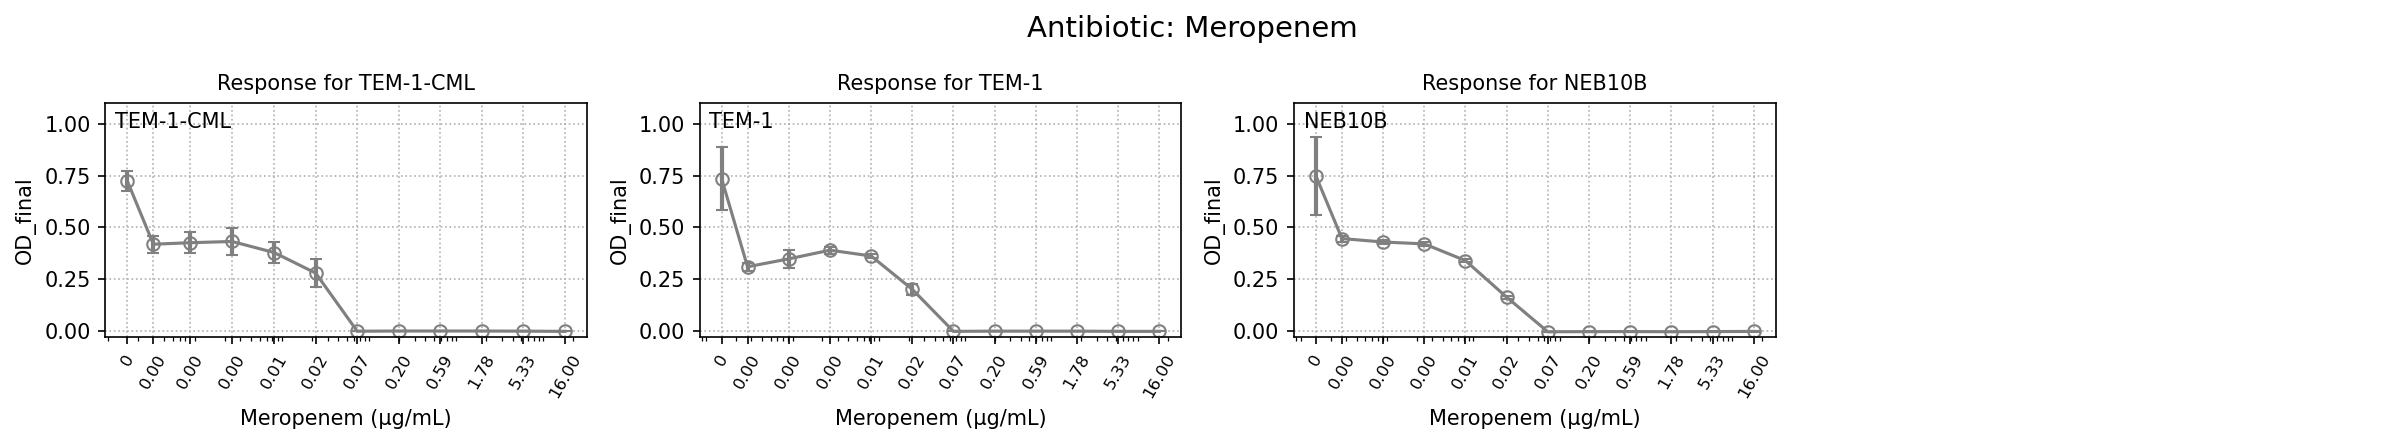

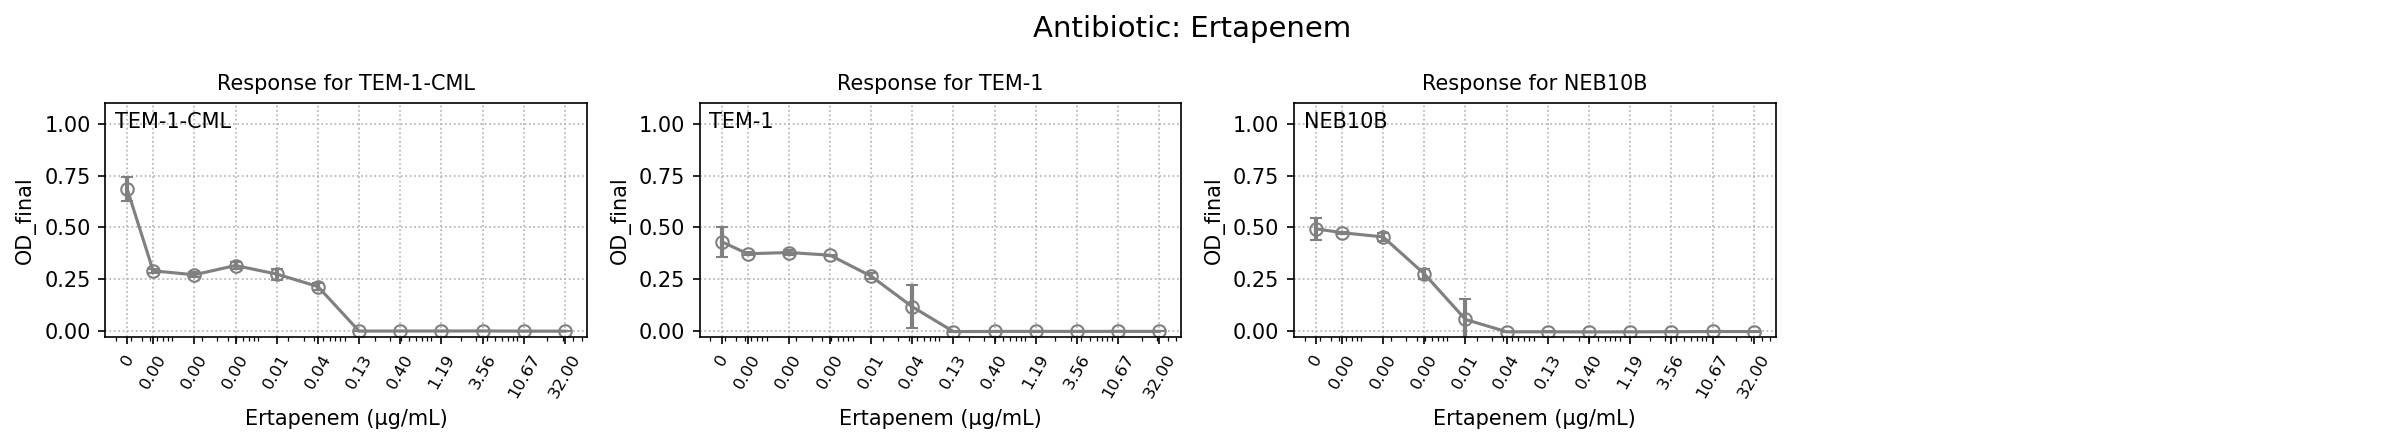

In [33]:
# Plot all dose-response curves in the df_analysis tables (might take too long)
for drug in antibiotics:
    if not pd.isna(drug):
        plategig.static.plot_od_final_for_selected_antibiotic(
            df_analysis,
            plategig.static.plot_dose_response_curve_errorbar,
            drug,
            strain_colors={})

In [34]:
valid_combinations = plategig.static.prep_valid_combinations(
    df_analysis,
    multiplex=['Strain', 'Antibiotic'],
    ic50_threshold=0.5,
    mic_threshold=0.05)
valid_combinations

Strain  Antibiotic
0                          NEB10B  Ampicillin
1   NEB10B_MIC_test_range_changed   Aztreonam
2                           TEM-1  Ampicillin
3         TEM-1_MIC_range_changed   Aztreonam
4                       TEM-1-CML  Ampicillin
..                            ...         ...
68                      TEM-1-CML    Imipenem
69                      TEM-1-CML   Meropenem
70                         NEB10B   Ertapenem
71                          TEM-1   Ertapenem
72                      TEM-1-CML   Ertapenem

[73 rows x 2 columns]

In [35]:
growth_features = plategig.static.apply_phenotyper(df_analysis, valid_combinations)
growth_features = plategig.static.cap_growth_features_within_experiment_range(growth_features)
growth_features

Strain  Antibiotic Status         IC50  \
0                          NEB10B  Ampicillin   PASS     1.469104   
1   NEB10B_MIC_test_range_changed   Aztreonam   PASS     0.257024   
2                           TEM-1  Ampicillin   PASS  8903.939386   
3         TEM-1_MIC_range_changed   Aztreonam   PASS     0.403655   
4                       TEM-1-CML  Ampicillin   PASS  3188.585885   
..                            ...         ...    ...          ...   
68                      TEM-1-CML    Imipenem   PASS     0.036841   
69                      TEM-1-CML   Meropenem   PASS     0.010905   
70                         NEB10B   Ertapenem   PASS     0.005705   
71                          TEM-1   Ertapenem   PASS     0.025649   
72                      TEM-1-CML   Ertapenem   PASS     0.015209   

             MIC  IC50_ci_lower  IC50_ci_upper  MIC_ci_lower  MIC_ci_upper  \
0       1.748031       1.158963       1.497862      1.664849      3.692011   
1       0.413330       0.148533       0.308346      0.170294      0.605529   
2   38346.318498    8153.433662    9545.872947  34487.426452  41796.448054   
3       0.457388       0.160741       0.419530      0.202201      0.866219   
4   10455.910642    2476.911483    3815.259000   7668.730911  11848.854063   
..           ...            ...            ...           ...           ...   
68      9.253909       0.021682       0.048126      4.522538     35.640290   
69      0.277768       0.007136       0.014676      0.155153      0.758517   
70      0.020332       0.005081       0.007341      0.007729      0.052680   
71      0.131785       0.016791       0.033904      0.027513      0.220614   
72      0.715101       0.008034       0.020007      0.384398      2.531660   

    max_growth  hill_coeff  ic50_threshold  mic_threshold  \
0       0.3190   16.937874         0.15950       0.015950   
1       0.2755    6.197800         0.13775       0.013775   
2       0.3585    2.016512         0.17925       0.017925   
3       0.2850   23.560999         0.14250       0.014250   
4       0.3285    2.479340         0.16425       0.016425   
..         ...         ...             ...            ...   
68      0.5290    0.532814         0.26450       0.026450   
69      0.5765    0.909461         0.28825       0.028825   
70      0.4735    2.316787         0.23675       0.023675   
71      0.3760    1.799046         0.18800       0.018800   
72      0.4640    0.764688         0.23200       0.023200   

                                                x_fit  \
0   [0.254026315, 0.2878420164674974, 0.3261592266...   
1   [0.07407407407407407, 0.08393473269744274, 0.0...   
2   [0.254026315, 0.2878420164674974, 0.3261592266...   
3   [0.07407407407407407, 0.08393473269744274, 0.0...   
4   [0.254026315, 0.2878420164674974, 0.3261592266...   
..                                                ...   
68  [0.00013548070246744226, 0.0001535157433880983...   
69  [0.00015000000000000004, 0.0001697931381061869...   
70  [0.0002709614049348845, 0.00030703148677619664...   
71  [0.0002709614049348845, 0.00030703148677619664...   
72  [0.0002709614049348845, 0.00030703148677619664...   

                                                y_fit  \
0   [0.3189999999999607, 0.3189999999996738, 0.318...   
1   [0.27537662874832547, 0.2752324683668794, 0.27...   
2   [0.3584999997545053, 0.35849999968414387, 0.35...   
3   [0.28500000000000003, 0.28500000000000003, 0.2...   
4   [0.32849999997738394, 0.32849999996916923, 0.3...   
..                                                ...   
68  [0.5035920751638111, 0.5019321311841686, 0.500...   
69  [0.5650425509558923, 0.5637057591777671, 0.562...   
70  [0.4730934691286513, 0.4729571084990677, 0.472...   
71  [0.37589532113982427, 0.37586893927172055, 0.3...   
72  [0.44361045433827706, 0.4416641878077893, 0.43...   

                                       ic50_bootstrap  insufficient_drug  
0   [1.4979805903368877, 1.4748356317599371, 1.480...              False  
1   [0.2

In [36]:
# growth_features['group'] = growth_features['Strain'].apply(lambda x: re.split(r'[1-9]', x)[0])
# growth_features

In [37]:
strains = list(set(df_analysis['Strain'].str.lower()) - set(['media only', 'cells only', np.nan]))
print(strains)

['l21p-e104k-r164n-e240k-t265m', 'q39k-e104k-r164s-e240k-t265m', 'l21p-e104k-r164n-m182t-e240k', 'neb10b', 'q39k-e104k-r164n-e240k', 'tem-1', 'neb10b_mic_test_range_changed', 'e104k-r164n-m182t-e240k', 'tem-1_mic_range_changed', 'e104k-r164n-e240k-t265m', 'tem-1-cml', 'neb10b_mic_range_changed', 'q39k-e104k-r164n-m182t-e240k']


In [38]:
antibiotics = list(set(df_analysis['Antibiotic'].str.lower()) - set(['media only', 'cells only', np.nan]))
antibiotics

['cefotaxime',
 'imipenem',
 'meropenem',
 'ertapenem',
 'ampicillin',
 'ceftazidime',
 'cefepime',
 'ceftriaxone',
 'aztreonam']

In [39]:
strain_colors = {strain:color for strain, color in zip(strains, sns.color_palette('muted')[:len(strains)])}


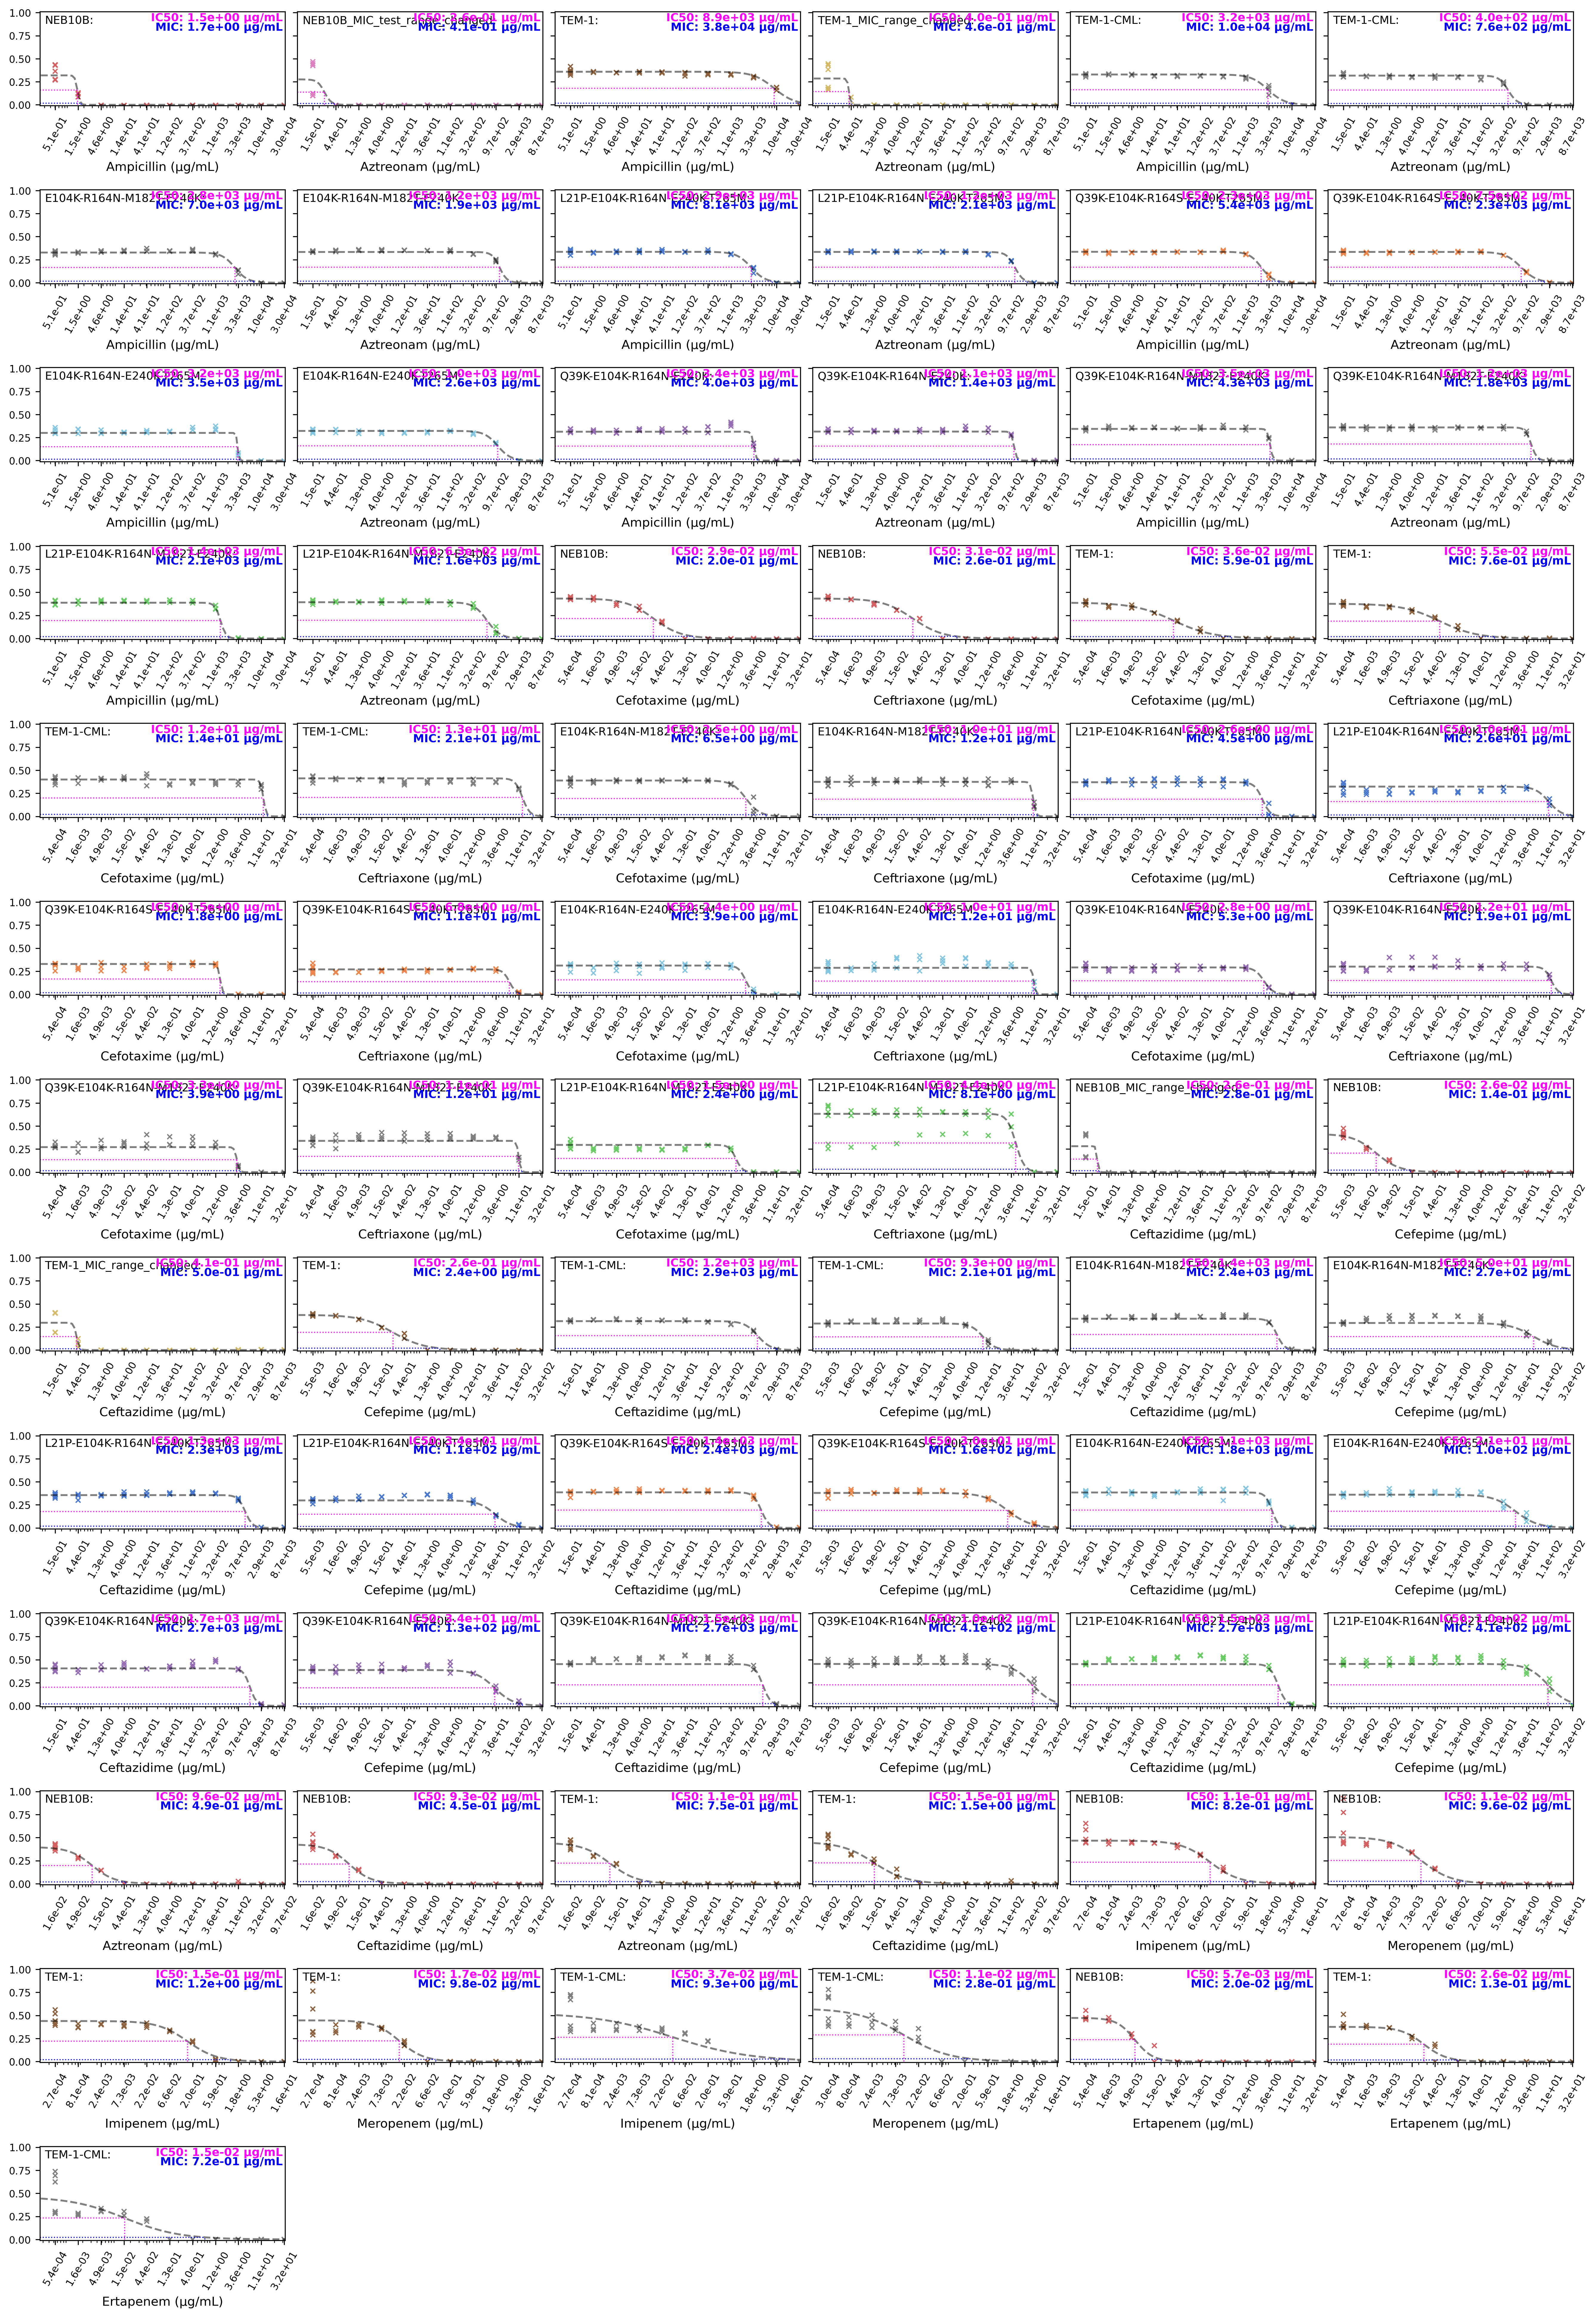

In [40]:
num_drugs = growth_features['Antibiotic'].nunique()
num_experiments = growth_features.shape[0]
num_cols = 6
num_rows = num_experiments//num_cols + (num_experiments % num_cols > 0)
# num_cols = num_experiments//num_drugs
# fig, axes = plt.subplots(num_experiments//num_replicates, num_replicates,
#                        figsize=(num_replicates*3, num_experiments*2), dpi=90)
fig, axes = plt.subplots(num_rows, num_cols,
                       figsize=(num_cols*3, num_rows*2), dpi=300)

for ix, row in growth_features.iterrows():
    plategig.static.plot_dose_response_curve_fit(df_analysis,
                                                growth_features=growth_features,
                                                strain_colors=strain_colors,
                                                strain=row['Strain'],
                                                antibiotic=row['Antibiotic'],
                                                ax=axes.flat[ix])
    
    if row['Status'] == 'FAIL':
        axes.flat[ix].text(0.5, 0.5, f'FAIL', color='red', fontsize=12, fontweight='bold',
                        ha='center', va='center', transform=axes.flat[ix].transAxes)
        # gray out the entire axes
        axes.flat[ix].set_facecolor('lightgray')
    if ix % num_cols != 0:
        axes.flat[ix].set_yticklabels([])
# Hide the rest of the axes
for ix in range(num_experiments, num_cols*num_rows):
    axes.flat[ix].axis('off')
    
fig.tight_layout()
# set empty space between subplots
fig.subplots_adjust(wspace=0.05)
fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / f'IC50 fits.png', dpi=300, bbox_inches='tight')

In [41]:
unique_columns = growth_features.columns.unique()
print(unique_columns)

Index(['Strain', 'Antibiotic', 'Status', 'IC50', 'MIC', 'IC50_ci_lower',
       'IC50_ci_upper', 'MIC_ci_lower', 'MIC_ci_upper', 'max_growth',
       'hill_coeff', 'ic50_threshold', 'mic_threshold', 'x_fit', 'y_fit',
       'ic50_bootstrap', 'insufficient_drug'],
      dtype='object')


In [45]:
#### Graphes the IC50 values for each with a confindence interval
    ### looks like it pulls growth_features

final_chart = alt.vconcat()
for drug in sorted(growth_features['Antibiotic'].unique()):
    select_cols = ['Strain','Antibiotic','Status','IC50','IC50_ci_lower','IC50_ci_upper', 'insufficient_drug']
    filtered_growth_features = growth_features[select_cols]
    filtered_growth_features = filtered_growth_features.query(f'Antibiotic == "{drug}" & Status == "PASS"')
    filtered_growth_features['StrainGroup'] = filtered_growth_features['Strain']#.str.extract(r'(\D+)')

    base = alt.Chart(filtered_growth_features).encode(
        x=alt.X('Strain', axis=alt.Axis(labelAngle=-45, labelLimit=0)),
    ).properties(width=700, height=300)

    ic50 = base.encode(
        y=alt.Y('IC50:Q', scale=alt.Scale(type="log")),
        color=alt.Color("StrainGroup:N")
    ).mark_point(filled=True, size=200)

    error_bars = base.mark_errorbar(ticks=True, size=10, thickness=2).encode(
        alt.Y("IC50_ci_lower:Q", scale=alt.Scale(type="log")).title('IC50'),
        alt.Y2("IC50_ci_upper:Q"),
        color='StrainGroup'
    )

    # Create a dagger symbol on the bars with insufficient_drug flag is true
    dagger = base.mark_text(align='center', baseline='middle', fontSize=14, color='black', fontWeight='bold', dy=-20, dx=0).encode(
        y=alt.Y('IC50'),
        text=alt.condition(
            alt.datum.insufficient_drug, if_true=alt.value("‡"), if_false=alt.value("")
            )
    )

    layered_chart = alt.layer(ic50, error_bars, dagger).properties(title=drug)
    final_chart &= layered_chart

final_chart = final_chart.resolve_scale(y='independent', x='independent').configure_axis(
    labelFontSize=16,
    titleFontSize=16,
).configure_title(
    fontSize=16,
    anchor='middle',
).configure_legend(
    titleFontSize=16,
    labelFontSize=16,
    labelLimit=0,
    symbolLimit=50,
)

final_chart = final_chart.configure_title(anchor='middle')
final_chart.save(PROJECT_PATH / PROJECT_ID / 'figures' / f'IC50 combined.png', scale_factor=2)
final_chart.show()

alt.VConcatChart(...)

In [46]:
#### Graphs the MIC values for each with a confidence interval
    ### looks like it pulls growth_features

final_chart = alt.vconcat()
for drug in sorted(growth_features['Antibiotic'].unique()):
    select_cols = ['Strain','Antibiotic','Status','MIC','MIC_ci_lower','MIC_ci_upper', 'insufficient_drug']
    filtered_growth_features = growth_features[select_cols]
    filtered_growth_features = filtered_growth_features.query(f'Antibiotic == "{drug}" & Status == "PASS"')
    filtered_growth_features['StrainGroup'] = filtered_growth_features['Strain']#.str.extract(r'(\D+)')

    base = alt.Chart(filtered_growth_features).encode(
        x=alt.X('Strain', axis=alt.Axis(labelAngle=-45, labelLimit=0)),
    ).properties(width=700, height=300)

    mic = base.encode(
        y=alt.Y('MIC:Q', scale=alt.Scale(type="log")),
        color=alt.Color("StrainGroup:N")
    ).mark_point(filled=True, size=200)

    error_bars = base.mark_errorbar(ticks=True, size=10, thickness=2).encode(
        alt.Y("MIC_ci_lower:Q", scale=alt.Scale(type="log")).title('MIC'),
        alt.Y2("MIC_ci_upper:Q"),
        color='StrainGroup'
    )

    # Create a dagger symbol on the bars with insufficient_drug flag is true
    dagger = base.mark_text(align='center', baseline='middle', fontSize=14, color='black', fontWeight='bold', dy=-20, dx=0).encode(
        y=alt.Y('MIC'),
        text=alt.condition(
            alt.datum.insufficient_drug, if_true=alt.value("‡"), if_false=alt.value("")
            )
    )

    layered_chart = alt.layer(mic, error_bars, dagger).properties(title=drug)
    final_chart &= layered_chart

final_chart = final_chart.resolve_scale(y='independent', x='independent').configure_axis(
    labelFontSize=16,
    titleFontSize=16,
).configure_title(
    fontSize=16,
    anchor='middle',
).configure_legend(
    titleFontSize=16,
    labelFontSize=16,
    labelLimit=0,
    symbolLimit=50,
)

final_chart = final_chart.configure_title(anchor='middle')
final_chart.save(PROJECT_PATH / PROJECT_ID / 'figures' / f'MIC combined.png', scale_factor=2)
final_chart.show()

alt.VConcatChart(...)

In [60]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Nimbus Roman"

import re
manual_colors = {
    "P": "grey",
    "PLA": "blue",
    "PLAC": "forestgreen",
    "PL": "red"
}

def cohort_label(group):
    if group == "P":
        return "MG"
    elif group == "PL":
        return "MG$^{\\mathrm{LEV}}$"
    elif group == "PLA":
        return "MG$^{\\mathrm{LEV,AMI}}$"
    elif group == "PLAC":
        return "MG$^{\\mathrm{LEV,AMI,CEF}}$"
    else:
        return group  # Default to the original group name if no match
    

def custom_label(strain):
    # Match patterns for different strain types
    match = re.match(r'(P|PL|PLA|PLAC)(\d+)', strain)
    if match:
        prefix, number = match.groups()  # Extract group and number
        if prefix == "P":
            return f"MG-{number}"
        elif prefix == "PL":
            return f"MG$^{{\\mathrm{{LEV}}}}$-{number}"
        elif prefix == "PLA":
            return f"MG$^{{\\mathrm{{LEV,AMI}}}}$-{number}"
        elif prefix == "PLAC":
            return f"MG$^{{\\mathrm{{LEV,AMI,CEF}}}}$-{number}"
    # Default to the original strain label if no match
    return strain

print("Order of strains to be plotted:")
print(growth_features['Strain'].to_list())
# Dictionary of custom y-axis ranges for specific drugs
y_axis_ranges = {
    "Levofloxacin": (0.001, 10),
    "Amikacin": (.1, 1000),
    "Cefepime": (0.001, 10)
}

# Iterate over antibiotics to create subplots
fig, axes = plt.subplots(
    nrows=len(sorted(growth_features['Antibiotic'].unique())),
    figsize=(14, 18),
    constrained_layout=True
)

# Ensure axes is iterable even for a single plot
if len(sorted(growth_features['Antibiotic'].unique())) == 1:
    axes = [axes]

for ax, drug in zip(axes, sorted(growth_features['Antibiotic'].unique())):
    filtered_data = growth_features.query(f'Antibiotic == "{drug}" & Status == "PASS"')
    filtered_data['StrainGroup'] = filtered_data['Strain'].str.extract(r'(\D+)')

    # Add a sort key to maintain original strain order within the dataset
    filtered_data['SortOrder'] = filtered_data.index

    # Apply custom labels
    filtered_data['CustomLabel'] = filtered_data['Strain'].apply(custom_label)

    # Sort the labels numerically within groups, respecting original order
    filtered_data['NumericPart'] = filtered_data['Strain'].str.extract(r'(\d+)$').astype(int)
    filtered_data = filtered_data.sort_values(['StrainGroup', 'NumericPart', 'SortOrder'])

    # Extract values for plotting
    strains = filtered_data['CustomLabel']
    ic50 = filtered_data['IC50']
    ci_lower = filtered_data['IC50_ci_lower']
    ci_upper = filtered_data['IC50_ci_upper']
    insufficient_drug = filtered_data['insufficient_drug']
    strain_groups = filtered_data['StrainGroup']

    # Assign colors for each strain group
    unique_groups = strain_groups.unique()
    group_colors = {group: manual_colors.get(group, "black") for group in unique_groups}
    colors = strain_groups.map(group_colors)

    # Plot IC50 points
    scatter = ax.scatter(strains, ic50, color=colors, s=100, label=strain_groups)
    
    # Add error bars with matching colors
    for i, color in enumerate(colors):
        ax.errorbar(
            x=i,
            y=ic50.iloc[i],
            yerr=[[ic50.iloc[i] - ci_lower.iloc[i]], [ci_upper.iloc[i] - ic50.iloc[i]]],
            fmt='none',
            ecolor=color,
            capsize=3
        )

    # Add dagger annotations for insufficient drug
    for i, strain in enumerate(strains):
        if insufficient_drug.iloc[i]:
            ax.text(i, ic50.iloc[i] * 1.2, '‡', ha='center', va='bottom', fontsize=12, color='black')

    # Format the y-axis with log scale
    ax.set_yscale('log')
    
    # Apply custom y-axis range if the drug is in the dictionary
    if drug in y_axis_ranges:
        ax.set_ylim(y_axis_ranges[drug])

    ax.set_ylabel(f"{drug}\nIC$_{{50}}$ (μg/mL)", fontsize=22)
    ax.tick_params(axis='y', labelsize=22)  # Adjust 'labelsize' to your preferred size

    ax.set_xlim(-0.5, len(strains) - 0.5)  # Tighten edges by adding a small buffer
    
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Set thickness of the spine lines
    
    ax.tick_params(axis='both', which='major', length=12, width=3)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=8, width=2)  # Minor ticks

    if drug == 'Levofloxacin':
        ax.set_xlabel('Culture', fontsize=22, labelpad=40)         
        # Calculate repeated labels
        repeated_labels = [str(i) for i in range(1, 11)] * (len(strains) // 10 + 1)
        repeated_labels = repeated_labels[:len(strains)]
        
        # Set xticks and xticklabels
        ax.set_xticks(range(len(strains)))
        ax.set_xticklabels(repeated_labels, fontsize=15)

        # Calculate unique cohort groups and their midpoints
        cohort_midpoints = []
        current_group = strain_groups.iloc[0]
        group_start = 0

        for i, group in enumerate(strain_groups):
            if group != current_group:
                midpoint = (group_start + i - 1) / 2
                cohort_midpoints.append((current_group, midpoint))
                group_start = i
                current_group = group
        
        # Add the last group
        midpoint = (group_start + len(strain_groups) - 1) / 2
        cohort_midpoints.append((current_group, midpoint))

        # Add cohort labels below the x-axis
        for group, midpoint in cohort_midpoints:
            ax.text(midpoint / len(strains)*1.02, -0.1, cohort_label(group), fontsize=18, 
                    ha='center', va='top', transform=ax.transAxes)

        # Create a legend with cohort labels
        handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='', 
                              label=cohort_label(group)) for group, color in group_colors.items()]
        ax.legend(handles=handles, title="Cohort", loc="upper left", fontsize=15, title_fontsize=15)

    else:
        ax.set_xticklabels("")  # Keep empty xticklabels for other subplots

final_chart_path = PROJECT_PATH / PROJECT_ID / 'figures'/'finals'/'0512_finals' / 'PLAC_IC50_individual.png'
plt.savefig(final_chart_path, dpi=600, bbox_inches='tight')
plt.show()
# Show plot
plt.show()


Order of strains to be plotted:
['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'PL1', 'PL2', 'PL3', 'PL4', 'PL5', 'PL6', 'PL7', 'PL8', 'PL9', 'PL10', 'PLA1', 'PLA2', 'PLA3', 'PLA4', 'PLA5', 'PLA6', 'PLA7', 'PLA8', 'PLA9', 'PLA10', 'PLAC1', 'PLAC2', 'PLAC3', 'PLAC4', 'PLAC5', 'PLAC6', 'PLAC8', 'PLAC9', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'PL1', 'PL2', 'PL3', 'PL4', 'PL5', 'PL6', 'PL7', 'PL8', 'PL9', 'PL10', 'PLA1', 'PLA2', 'PLA3', 'PLA4', 'PLA5', 'PLA6', 'PLA7', 'PLA8', 'PLA9', 'PLA10', 'PLAC1', 'PLAC2', 'PLAC3', 'PLAC4', 'PLAC5', 'PLAC6', 'PLAC8', 'PLAC9', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'PL1', 'PL2', 'PL3', 'PL4', 'PL5', 'PL6', 'PL7', 'PL8', 'PL9', 'PL10', 'PLA1', 'PLA2', 'PLA3', 'PLA4', 'PLA5', 'PLA6', 'PLA7', 'PLA8', 'PLA9', 'PLA10', 'PLAC1', 'PLAC2', 'PLAC3', 'PLAC4', 'PLAC5', 'PLAC6', 'PLAC8', 'PLAC9', 'PLAC7', 'PLAC10', 'PLAC7', 'PLAC10', 'PLAC7', 'PLAC10']


/tmp/ipykernel_41724/3680381024.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['StrainGroup'] = filtered_data['Strain'].str.extract(r'(\D+)')
/tmp/ipykernel_41724/3680381024.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['SortOrder'] = filtered_data.index
/tmp/ipykernel_41724/3680381024.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Order of strains to be plotted:
['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'PL1', 'PL2', 'PL3', 'PL4', 'PL5', 'PL6', 'PL7', 'PL8', 'PL9', 'PL10', 'PLA1', 'PLA2', 'PLA3', 'PLA4', 'PLA5', 'PLA6', 'PLA7', 'PLA8', 'PLA9', 'PLA10', 'PLAC1', 'PLAC2', 'PLAC3', 'PLAC4', 'PLAC5', 'PLAC6', 'PLAC8', 'PLAC9', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'PL1', 'PL2', 'PL3', 'PL4', 'PL5', 'PL6', 'PL7', 'PL8', 'PL9', 'PL10', 'PLA1', 'PLA2', 'PLA3', 'PLA4', 'PLA5', 'PLA6', 'PLA7', 'PLA8', 'PLA9', 'PLA10', 'PLAC1', 'PLAC2', 'PLAC3', 'PLAC4', 'PLAC5', 'PLAC6', 'PLAC8', 'PLAC9', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'PL1', 'PL2', 'PL3', 'PL4', 'PL5', 'PL6', 'PL7', 'PL8', 'PL9', 'PL10', 'PLA1', 'PLA2', 'PLA3', 'PLA4', 'PLA5', 'PLA6', 'PLA7', 'PLA8', 'PLA9', 'PLA10', 'PLAC1', 'PLAC2', 'PLAC3', 'PLAC4', 'PLAC5', 'PLAC6', 'PLAC8', 'PLAC9', 'PLAC7', 'PLAC10', 'PLAC7', 'PLAC10', 'PLAC7', 'PLAC10']


/tmp/ipykernel_41724/3280701448.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['StrainGroup'] = filtered_data['Strain'].str.extract(r'(\D+)')
/tmp/ipykernel_41724/3280701448.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['SortOrder'] = filtered_data.index
/tmp/ipykernel_41724/3280701448.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

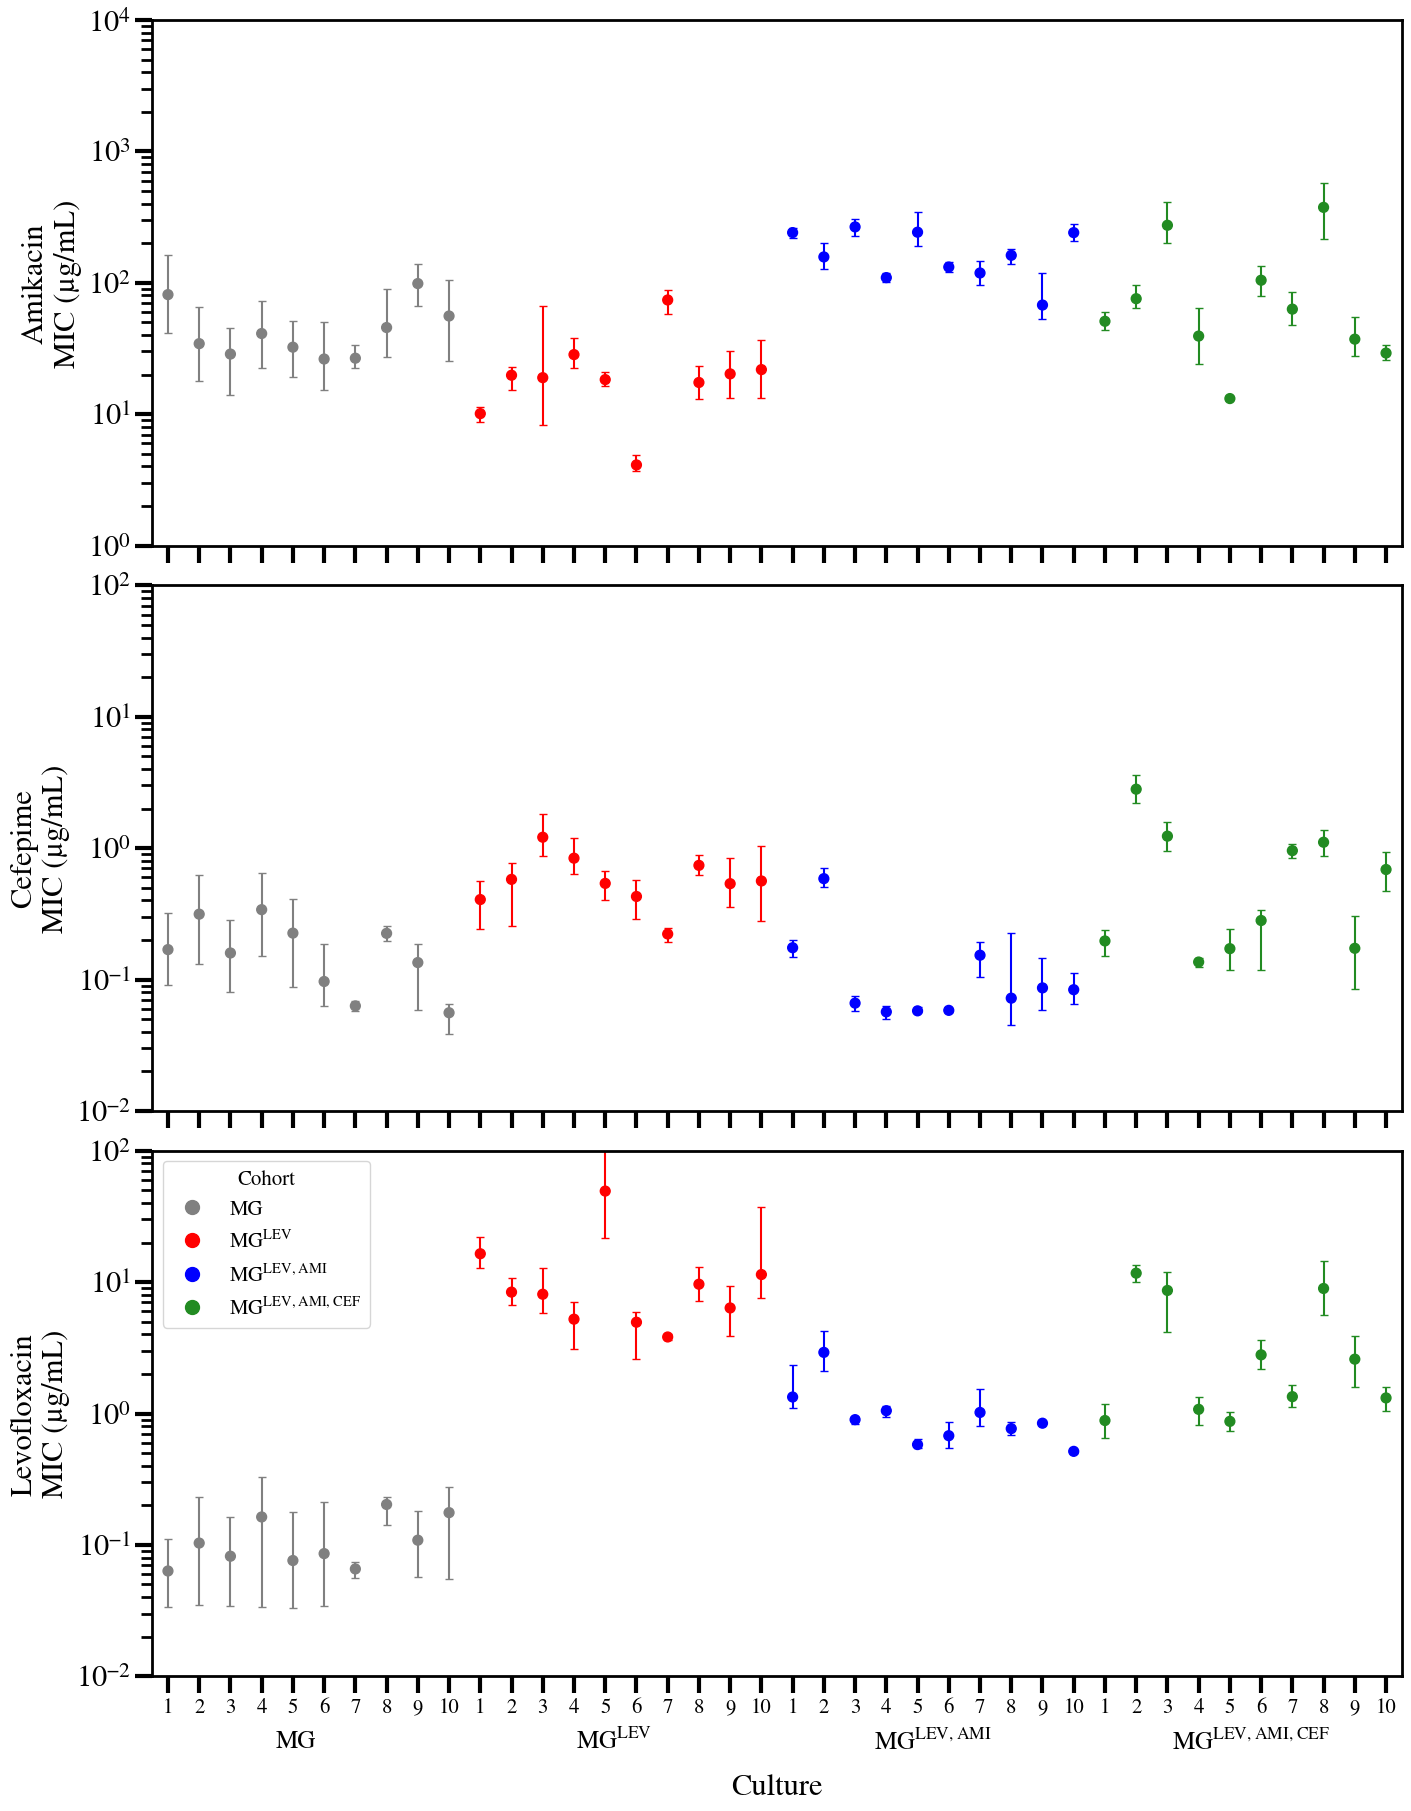

In [61]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Nimbus Roman"

import re
manual_colors = {
    "P": "grey",
    "PLA": "blue",
    "PLAC": "forestgreen",
    "PL": "red"
}

def cohort_label(group):
    if group == "P":
        return "MG"
    elif group == "PL":
        return "MG$^{\\mathrm{LEV}}$"
    elif group == "PLA":
        return "MG$^{\\mathrm{LEV,AMI}}$"
    elif group == "PLAC":
        return "MG$^{\\mathrm{LEV,AMI,CEF}}$"
    else:
        return group  # Default to the original group name if no match
    
def custom_label(strain):
    # Match patterns for different strain types
    match = re.match(r'(P|PL|PLA|PLAC)(\d+)', strain)
    if match:
        prefix, number = match.groups()  # Extract group and number
        if prefix == "P":
            return f"MG-{number}"
        elif prefix == "PL":
            return f"MG$^{{\\mathrm{{LEV}}}}$-{number}"
        elif prefix == "PLA":
            return f"MG$^{{\\mathrm{{LEV,AMI}}}}$-{number}"
        elif prefix == "PLAC":
            return f"MG$^{{\\mathrm{{LEV,AMI,CEF}}}}$-{number}"
    # Default to the original strain label if no match
    return strain
print("Order of strains to be plotted:")
print(growth_features['Strain'].to_list())
# Dictionary of custom y-axis ranges for specific drugs
y_axis_ranges = {
    "Levofloxacin": (0.01, 100),
    "Amikacin": (1, 10000),
    "Cefepime": (0.01, 100)
}


# Iterate over antibiotics to create subplots
fig, axes = plt.subplots(
    nrows=len(sorted(growth_features['Antibiotic'].unique())),
    figsize=(14, 18),
    constrained_layout=True
)

# Ensure axes is iterable even for a single plot
if len(sorted(growth_features['Antibiotic'].unique())) == 1:
    axes = [axes]

for ax, drug in zip(axes, sorted(growth_features['Antibiotic'].unique())):
    filtered_data = growth_features.query(f'Antibiotic == "{drug}" & Status == "PASS"')
    filtered_data['StrainGroup'] = filtered_data['Strain'].str.extract(r'(\D+)')

    # Add a sort key to maintain original strain order within the dataset
    filtered_data['SortOrder'] = filtered_data.index

    # Apply custom labels
    filtered_data['CustomLabel'] = filtered_data['Strain'].apply(custom_label)

    # Sort the labels numerically within groups, respecting original order
    filtered_data['NumericPart'] = filtered_data['Strain'].str.extract(r'(\d+)$').astype(int)
    filtered_data = filtered_data.sort_values(['StrainGroup', 'NumericPart', 'SortOrder'])


    # Extract values for plotting
    strains = filtered_data['CustomLabel']
    mic50 = filtered_data['MIC']
    ci_lower = filtered_data['MIC_ci_lower']
    ci_upper = filtered_data['MIC_ci_upper']
    insufficient_drug = filtered_data['insufficient_drug']
    strain_groups = filtered_data['StrainGroup']

    # Assign colors for each strain group
    unique_groups = strain_groups.unique()
    group_colors = {group: manual_colors.get(group, "black") for group in unique_groups}
    colors = strain_groups.map(group_colors)

    # Plot IC50 points
    scatter = ax.scatter(strains, mic50, color=colors, s=50, label=strain_groups)
    
    # Add error bars with matching colors
    for i, color in enumerate(colors):
        ax.errorbar(
            x=i,
            y=mic50.iloc[i],
            yerr=[[mic50.iloc[i] - ci_lower.iloc[i]], [ci_upper.iloc[i] - mic50.iloc[i]]],
            fmt='none',
            ecolor=color,
            capsize=3
        )

    # Add dagger annotations for insufficient drug
    for i, strain in enumerate(strains):
        if insufficient_drug.iloc[i]:
            ax.text(i, mic50.iloc[i] * 1.2, '‡', ha='center', va='bottom', fontsize=12, color='black')

    # Format the y-axis with log scale
    ax.set_yscale('log')
    
    # Apply custom y-axis range if the drug is in the dictionary
    if drug in y_axis_ranges:
        ax.set_ylim(y_axis_ranges[drug])

    ax.set_ylabel(f"{drug}\nMIC (μg/mL)", fontsize=22)
    ax.tick_params(axis='y', labelsize=22)  # Adjust 'labelsize' to your preferred size

    ax.set_xlim(-0.5, len(strains) - 0.5)  # Tighten edges by adding a small buffer

    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Set thickness of the spine lines


    ax.tick_params(axis='both', which='major', length=12, width=3)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=8, width=2)  # Minor ticks

    if drug == 'Levofloxacin':
        ax.set_xlabel('Culture', fontsize=22, labelpad=40)         
        # Calculate repeated labels
        repeated_labels = [str(i) for i in range(1, 11)] * (len(strains) // 10 + 1)
        repeated_labels = repeated_labels[:len(strains)]
        
        # Set xticks and xticklabels
        ax.set_xticks(range(len(strains)))
        ax.set_xticklabels(repeated_labels, fontsize=15)

        # Calculate unique cohort groups and their midpoints
        cohort_midpoints = []
        current_group = strain_groups.iloc[0]
        group_start = 0

        for i, group in enumerate(strain_groups):
            if group != current_group:
                midpoint = (group_start + i - 1) / 2
                cohort_midpoints.append((current_group, midpoint))
                group_start = i
                current_group = group
        
        # Add the last group
        midpoint = (group_start + len(strain_groups) - 1) / 2
        cohort_midpoints.append((current_group, midpoint))

        # Add cohort labels below the x-axis
        for group, midpoint in cohort_midpoints:
            ax.text(midpoint / len(strains)*1.02, -0.1, cohort_label(group), fontsize=18, 
                    ha='center', va='top', transform=ax.transAxes)

        # Create a legend with cohort labels
        handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='', 
                              label=cohort_label(group)) for group, color in group_colors.items()]
        ax.legend(handles=handles, title="Cohort", loc="upper left", fontsize=15, title_fontsize=15)

    else:
        ax.set_xticklabels("")  # Keep empty xticklabels for other subplots

final_chart_path = PROJECT_PATH / PROJECT_ID / 'figures'/'finals'/'0512_finals' / 'PLAC_MIC50_individual.png'
plt.savefig(final_chart_path, dpi=600, bbox_inches='tight')
plt.show()
# Show plot
plt.show()


In [32]:
(
growth_features[['Antibiotic','Strain','Status','IC50','MIC','IC50_ci_lower','IC50_ci_upper', 'max_growth', 'hill_coeff']]
.to_csv(PROJECT_PATH / PROJECT_ID / 'figures' / f'IC50 estimations.csv',
          index=False)
)

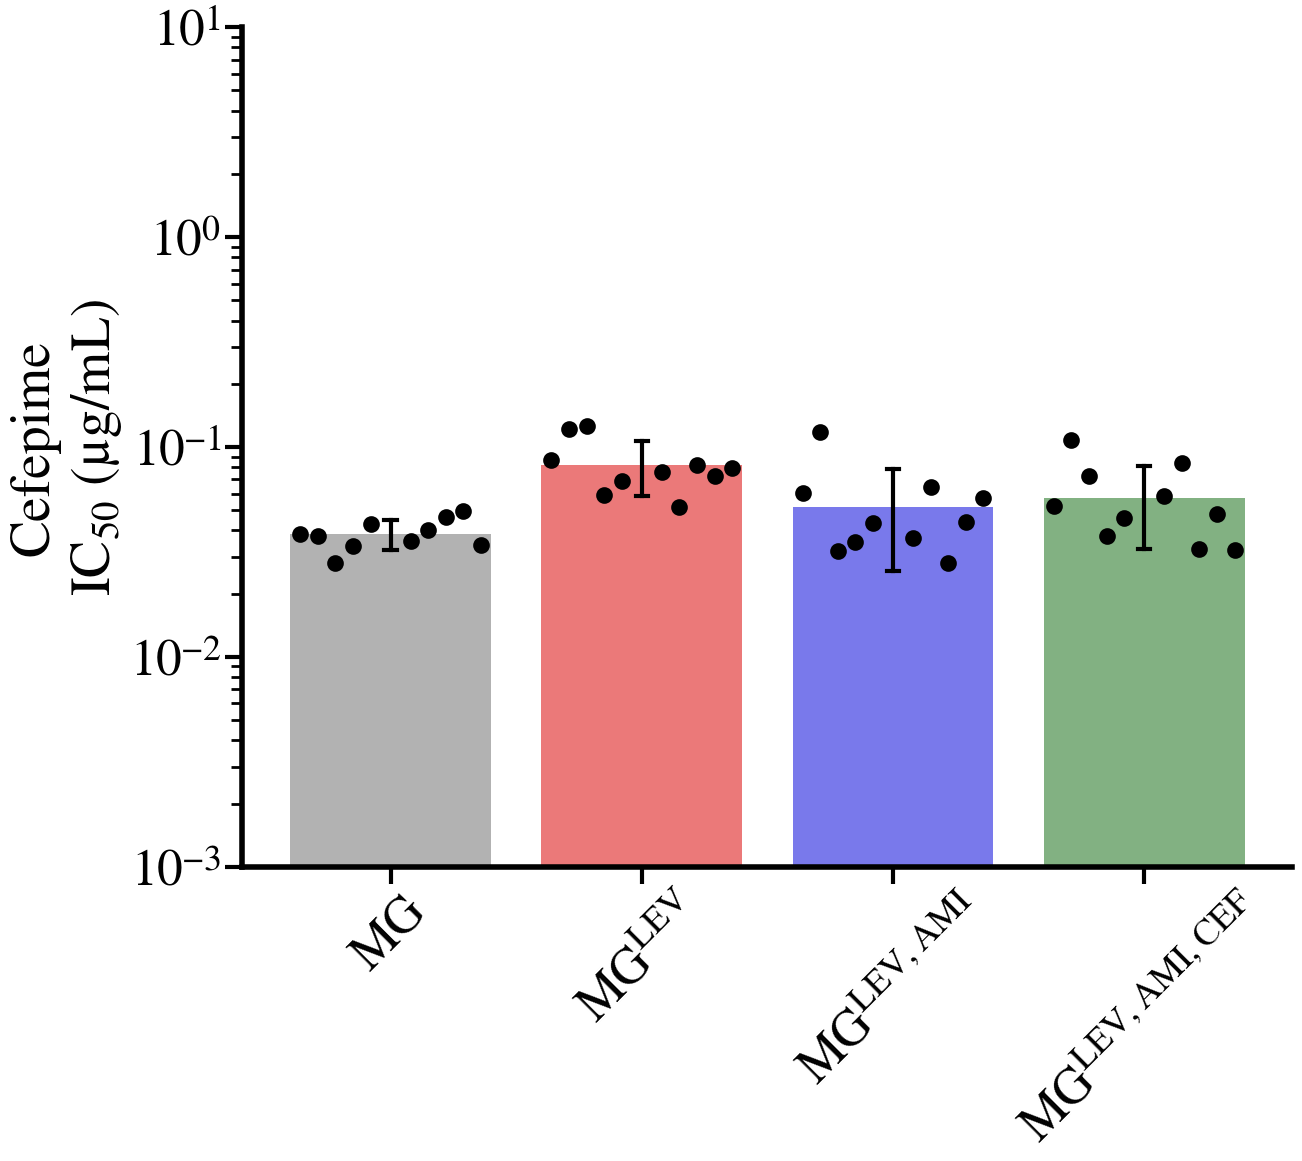

In [63]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Nimbus Roman"

######### LABELS
# Assign the antibiotic you want to graph
selected_antibiotic = "Cefepime"

# Subset the data for the selected antibiotic
subset_data = growth_features[growth_features['Antibiotic'] == selected_antibiotic].copy()  # Avoid SettingWithCopyWarning

# Custom y-axis limits for each antibiotic
custom_y_limits = {
    "Levofloxacin": (0.001, 10),
    "Amikacin": (.1, 1000),
    "Cefepime": (0.001, 10)
}

# Create a new column for the updated group labels
def assign_group_label(row):
    if row['group'] == "P":
        return r"MG"  # Just MG
    elif row['group'] == "PLA":
        return r"MG$^{\mathrm{LEV,AMI}}$"  # MG with AMI as superscript
    elif row['group'] == "PLAC":
        return r"MG$^{\mathrm{LEV,AMI,CEF}}$"  # MG with CEF as superscript
    elif row['group'] == "PL":
        return r"MG$^{\mathrm{LEV}}$"  # MG with LEV as superscript
    else:
        return "Unknown"

# Ensure the 'group' column exists
if 'group' not in subset_data.columns:
    subset_data['group'] = growth_features['Strain'].apply(lambda x: re.split(r'[1-9]', x)[0])

# Apply the function to create the new column
subset_data.loc[:, 'group_fancy'] = subset_data.apply(assign_group_label, axis=1)

# Update the palette to match the new group labels
group_palette = {
    r"MG": "grey",
    r"MG$^{\mathrm{LEV,AMI}}$": "blue",
    r"MG$^{\mathrm{LEV,AMI,CEF}}$": "forestgreen",
    r"MG$^{\mathrm{LEV}}$": "red",
}

# Use FacetGrid for plotting
g = sns.FacetGrid(
    subset_data,
    col="Antibiotic",  # Facet by Antibiotic
    sharey=False,  # Allow independent y-axis scaling
    height=10,  # Height of each facet
    aspect=1.5,  # Aspect ratio for width scaling
)

# Map bar plots to the grid
g.map(
    sns.barplot,
    "group_fancy",  # X-axis
    "IC50",  # Y-axis
    ci="sd",
    order=subset_data['group_fancy'].unique(),  # Ensure consistent x-axis order
    palette=group_palette,
    alpha=0.6,
    errcolor="black",  # Color of the error bars
    errwidth=3,  # Thickness of the error bars
    capsize=0.05  # Length of the caps on error bars
)

# Custom function to calculate evenly spaced x-positions
def get_evenly_spaced_positions(group_data, x_base, spread=0.36, gap=0.08):
    """
    Calculate evenly spaced x-positions around a central x_base, leaving a gap in the middle.

    Parameters:
        group_data: DataFrame containing points for a single category.
        x_base: Central x position for the category.
        spread: Maximum range to spread points around the center.
        gap: The size of the gap to leave in the middle (default: 0.1).

    Returns:
        List of adjusted x-positions for the points.
    """
    n_points = len(group_data)
    if n_points == 1:
        return [x_base]  # No need to spread if there's only one point

    half_points = n_points // 2  # Divide points into two halves
    if n_points % 2 == 0:
        # Even number of points
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        offsets = np.concatenate([left_offsets, right_offsets])
    else:
        # Odd number of points: one point stays at the center
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        center_offset = [0]  # Keep one point at the exact center
        offsets = np.concatenate([left_offsets, center_offset, right_offsets])

    return x_base + offsets

# Overlay strip plots with custom spacing
for group_fancy, group_data in subset_data.groupby('group_fancy'):
    x_base = subset_data['group_fancy'].unique().tolist().index(group_fancy)  # Base x position
    x_positions = get_evenly_spaced_positions(group_data, x_base)
    
    g.ax.scatter(
        x_positions,
        group_data['IC50'],
        color="black",
        facecolor="black",
        s=100,
        edgecolor="black",
        linewidth=2,
        zorder=10  # Ensure points are above other plot elements
    )


# Customizations for the y-axis and ticks
for ax in g.axes.flat:
    ax.set_yscale("log")  # Set log scale
    # Apply custom y-axis limits for the selected antibiotic
    if selected_antibiotic in custom_y_limits:
        ax.set_ylim(custom_y_limits[selected_antibiotic])
    # Let Seaborn/Matplotlib determine y-ticks automatically and just adjust their font size
    for label in ax.get_yticklabels():
        label.set_fontsize(37)  # Adjust font size for existing tick labels



 # Set x-tick positions and labels explicitly
    tick_positions = range(len(subset_data['group_fancy'].unique()))  # Create positions for each category
    ax.set_xticks(tick_positions)  # Set tick positions
    ax.set_xticklabels(subset_data['group_fancy'].unique(), rotation=45, ha="center", fontsize=37) 

    for spine in ax.spines.values():
        spine.set_linewidth(4)  # Set thickness of the sp

    ax.tick_params(axis='both', which='major', length=12, width=3)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=8, width=2)  # Minor ticks


# Add axis labels and facet titles

g.set_axis_labels("", f"{selected_antibiotic}\nIC$_{{50}}$ (μg/mL)", fontsize=40)
g.set_titles("", size=50)  # Facet title uses the column value

# Adjust overall layout and spacing
g.fig.subplots_adjust(left=0.2, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
g.fig.set_size_inches(15, 10)  # Total figure size

# Save the plot (optional)
#g.savefig(f"{selected_antibiotic}_IC50_plot_1127.png", dpi=300, bbox_inches="tight")
g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / 'finals'/'0512_finals'/ f"{selected_antibiotic}_PLAC_IC50_labels.png", dpi=600, bbox_inches="tight")
#g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / f'Cefepime_IC50_new', dpi=200, bbox_inches='tight')
# Show the plot
plt.show()


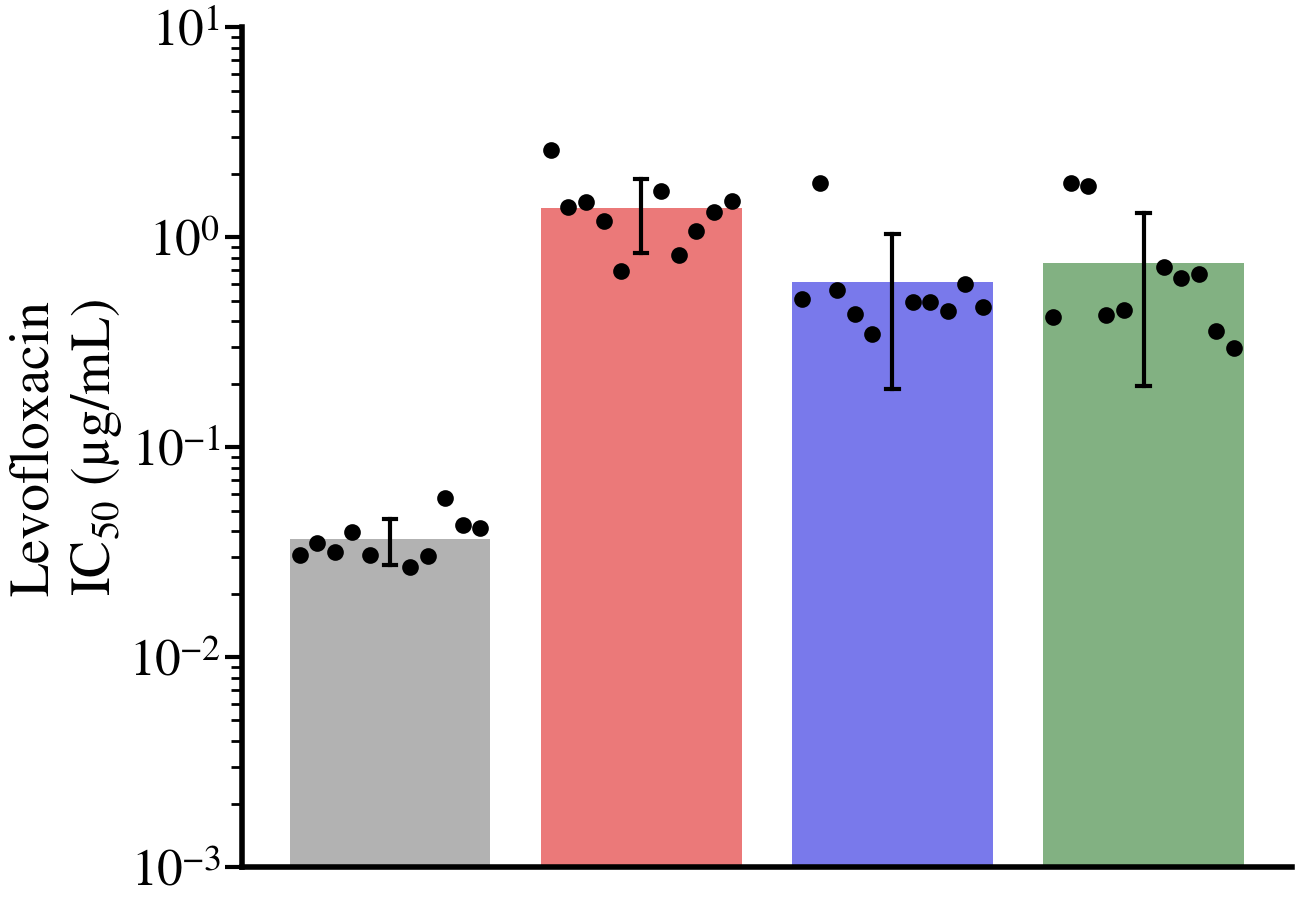

In [64]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Nimbus Roman"

######### NO LABELS
# Assign the antibiotic you want to graph
selected_antibiotic = "Levofloxacin"

# Subset the data for the selected antibiotic
subset_data = growth_features[growth_features['Antibiotic'] == selected_antibiotic].copy()  # Avoid SettingWithCopyWarning

# Custom y-axis limits for each antibiotic
custom_y_limits = {
    "Levofloxacin": (0.001, 10),
    "Amikacin": (.1, 1000),
    "Cefepime": (0.001, 10)
}

# Create a new column for the updated group labels
def assign_group_label(row):
    if row['group'] == "P":
        return r"MG"  # Just MG
    elif row['group'] == "PLA":
        return r"MG$^{\mathrm{LEV,AMI}}$"  # MG with AMI as superscript
    elif row['group'] == "PLAC":
        return r"MG$^{\mathrm{LEV,AMI,CEF}}$"  # MG with CEF as superscript
    elif row['group'] == "PL":
        return r"MG$^{\mathrm{LEV}}$"  # MG with LEV as superscript
    else:
        return "Unknown"

# Ensure the 'group' column exists
if 'group' not in subset_data.columns:
    subset_data['group'] = growth_features['Strain'].apply(lambda x: re.split(r'[1-9]', x)[0])

# Apply the function to create the new column
subset_data.loc[:, 'group_fancy'] = subset_data.apply(assign_group_label, axis=1)

# Update the palette to match the new group labels
group_palette = {
    r"MG": "grey",
    r"MG$^{\mathrm{LEV,AMI}}$": "blue",
    r"MG$^{\mathrm{LEV,AMI,CEF}}$": "forestgreen",
    r"MG$^{\mathrm{LEV}}$": "red",
}

# Use FacetGrid for plotting
g = sns.FacetGrid(
    subset_data,
    col="Antibiotic",  # Facet by Antibiotic
    sharey=False,  # Allow independent y-axis scaling
    height=10,  # Height of each facet
    aspect=1.5,  # Aspect ratio for width scaling
)

# Map bar plots to the grid
g.map(
    sns.barplot,
    "group_fancy",  # X-axis
    "IC50",  # Y-axis
    ci="sd",
    order=subset_data['group_fancy'].unique(),  # Ensure consistent x-axis order
    palette=group_palette,
    alpha=0.6,
    errcolor="black",  # Color of the error bars
    errwidth=3,  # Thickness of the error bars
    capsize=0.05  # Length of the caps on error bars
)

# Custom function to calculate evenly spaced x-positions
def get_evenly_spaced_positions(group_data, x_base, spread=0.36, gap=0.08):
    """
    Calculate evenly spaced x-positions around a central x_base, leaving a gap in the middle.

    Parameters:
        group_data: DataFrame containing points for a single category.
        x_base: Central x position for the category.
        spread: Maximum range to spread points around the center.
        gap: The size of the gap to leave in the middle (default: 0.1).

    Returns:
        List of adjusted x-positions for the points.
    """
    n_points = len(group_data)
    if n_points == 1:
        return [x_base]  # No need to spread if there's only one point

    half_points = n_points // 2  # Divide points into two halves
    if n_points % 2 == 0:
        # Even number of points
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        offsets = np.concatenate([left_offsets, right_offsets])
    else:
        # Odd number of points: one point stays at the center
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        center_offset = [0]  # Keep one point at the exact center
        offsets = np.concatenate([left_offsets, center_offset, right_offsets])

    return x_base + offsets

# Overlay strip plots with custom spacing
for group_fancy, group_data in subset_data.groupby('group_fancy'):
    x_base = subset_data['group_fancy'].unique().tolist().index(group_fancy)  # Base x position
    x_positions = get_evenly_spaced_positions(group_data, x_base)
    
    g.ax.scatter(
        x_positions,
        group_data['IC50'],
        color="black",
        facecolor="black",
        s=100,
        edgecolor="black",
        linewidth=2,
        zorder=10  # Ensure points are above other plot elements
    )


# Customizations for the y-axis and ticks
for ax in g.axes.flat:
    ax.set_yscale("log")  # Set log scale
    # Apply custom y-axis limits for the selected antibiotic
    if selected_antibiotic in custom_y_limits:
        ax.set_ylim(custom_y_limits[selected_antibiotic])
    # Let Seaborn/Matplotlib determine y-ticks automatically and just adjust their font size
    for label in ax.get_yticklabels():
        label.set_fontsize(37)  # Adjust font size for existing tick labels



 # Set x-tick positions and labels explicitly
    ax.set_xticks([])  # Remove tick positions
    ax.set_xticklabels([])  # Remove tick labels

    # Remove x-axis label
    ax.set_xlabel('')  # Remove x-axis label
    for spine in ax.spines.values():
        spine.set_linewidth(4)  # Set thickness of the spine lines

    ax.tick_params(axis='both', which='major', length=12, width=3)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=8, width=2)  # Minor ticks


# Add axis labels and facet titles
g.set_axis_labels("", "", fontsize=40)
g.set_axis_labels("", f"{selected_antibiotic}\nIC$_{{50}}$ (μg/mL)", fontsize=40)
g.set_titles("", size=50)  # Facet title uses the column value

# Adjust overall layout and spacing
g.fig.subplots_adjust(left=0.2, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
g.fig.set_size_inches(15, 10)  # Total figure size

# Save the plot (optional)
#g.savefig(f"{selected_antibiotic}_IC50_plot_1127.png", dpi=300, bbox_inches="tight")
g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures'/'finals'/'0512_finals' / f"{selected_antibiotic}_PLAC_IC50.png", dpi=600, bbox_inches="tight")
#g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / f'Cefepime_IC50_new', dpi=200, bbox_inches='tight')
# Show the plot
plt.show()


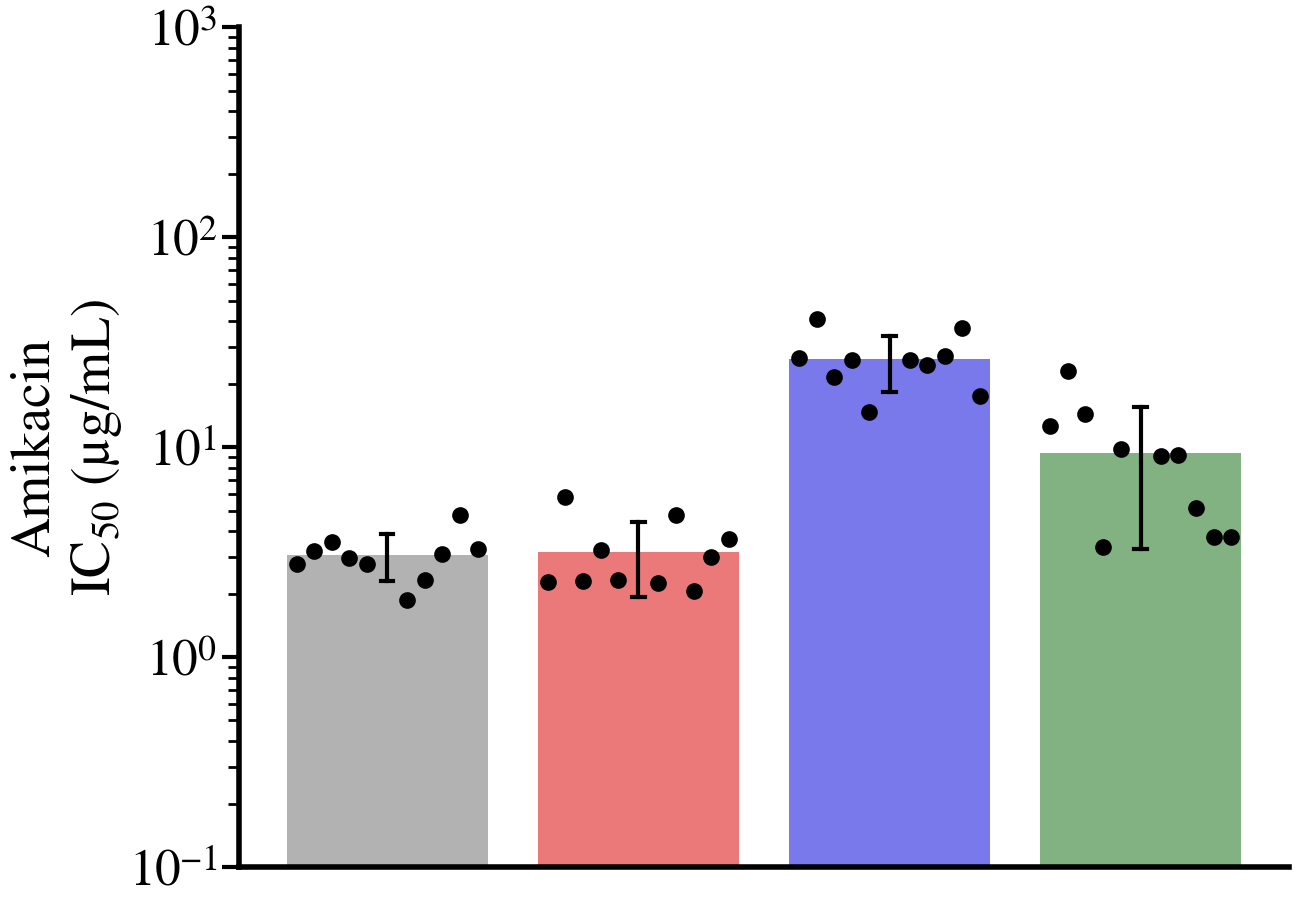

In [65]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Nimbus Roman"

######### NO LABELS
# Assign the antibiotic you want to graph
selected_antibiotic = "Amikacin"

# Subset the data for the selected antibiotic
subset_data = growth_features[growth_features['Antibiotic'] == selected_antibiotic].copy()  # Avoid SettingWithCopyWarning

# Custom y-axis limits for each antibiotic
custom_y_limits = {
    "Levofloxacin": (0.001, 10),
    "Amikacin": (.1, 1000),
    "Cefepime": (0.001, 10)
}

# Create a new column for the updated group labels
def assign_group_label(row):
    if row['group'] == "P":
        return r"MG"  # Just MG
    elif row['group'] == "PLA":
        return r"MG$^{\mathrm{LEV,AMI}}$"  # MG with AMI as superscript
    elif row['group'] == "PLAC":
        return r"MG$^{\mathrm{LEV,AMI,CEF}}$"  # MG with CEF as superscript
    elif row['group'] == "PL":
        return r"MG$^{\mathrm{LEV}}$"  # MG with LEV as superscript
    else:
        return "Unknown"

# Ensure the 'group' column exists
if 'group' not in subset_data.columns:
    subset_data['group'] = growth_features['Strain'].apply(lambda x: re.split(r'[1-9]', x)[0])

# Apply the function to create the new column
subset_data.loc[:, 'group_fancy'] = subset_data.apply(assign_group_label, axis=1)

# Update the palette to match the new group labels
group_palette = {
    r"MG": "grey",
    r"MG$^{\mathrm{LEV,AMI}}$": "blue",
    r"MG$^{\mathrm{LEV,AMI,CEF}}$": "forestgreen",
    r"MG$^{\mathrm{LEV}}$": "red",
}

# Use FacetGrid for plotting
g = sns.FacetGrid(
    subset_data,
    col="Antibiotic",  # Facet by Antibiotic
    sharey=False,  # Allow independent y-axis scaling
    height=10,  # Height of each facet
    aspect=1.5,  # Aspect ratio for width scaling
)

# Map bar plots to the grid
g.map(
    sns.barplot,
    "group_fancy",  # X-axis
    "IC50",  # Y-axis
    ci="sd",
    order=subset_data['group_fancy'].unique(),  # Ensure consistent x-axis order
    palette=group_palette,
    alpha=0.6,
    errcolor="black",  # Color of the error bars
    errwidth=3,  # Thickness of the error bars
    capsize=0.05  # Length of the caps on error bars
)

# Custom function to calculate evenly spaced x-positions
def get_evenly_spaced_positions(group_data, x_base, spread=0.36, gap=0.08):
    """
    Calculate evenly spaced x-positions around a central x_base, leaving a gap in the middle.

    Parameters:
        group_data: DataFrame containing points for a single category.
        x_base: Central x position for the category.
        spread: Maximum range to spread points around the center.
        gap: The size of the gap to leave in the middle (default: 0.1).

    Returns:
        List of adjusted x-positions for the points.
    """
    n_points = len(group_data)
    if n_points == 1:
        return [x_base]  # No need to spread if there's only one point

    half_points = n_points // 2  # Divide points into two halves
    if n_points % 2 == 0:
        # Even number of points
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        offsets = np.concatenate([left_offsets, right_offsets])
    else:
        # Odd number of points: one point stays at the center
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        center_offset = [0]  # Keep one point at the exact center
        offsets = np.concatenate([left_offsets, center_offset, right_offsets])

    return x_base + offsets

# Overlay strip plots with custom spacing
for group_fancy, group_data in subset_data.groupby('group_fancy'):
    x_base = subset_data['group_fancy'].unique().tolist().index(group_fancy)  # Base x position
    x_positions = get_evenly_spaced_positions(group_data, x_base)
    
    g.ax.scatter(
        x_positions,
        group_data['IC50'],
        color="black",
        facecolor="black",
        s=100,
        edgecolor="black",
        linewidth=2,
        zorder=10  # Ensure points are above other plot elements
    )


# Customizations for the y-axis and ticks
for ax in g.axes.flat:
    ax.set_yscale("log")  # Set log scale
   # Apply custom y-axis limits for the selected antibiotic
    if selected_antibiotic in custom_y_limits:
        ax.set_ylim(custom_y_limits[selected_antibiotic])
    # Let Seaborn/Matplotlib determine y-ticks automatically and just adjust their font size
    for label in ax.get_yticklabels():
        label.set_fontsize(37)  # Adjust font size for existing tick labels

 

 # Set x-tick positions and labels explicitly
    ax.set_xticks([])  # Remove tick positions
    ax.set_xticklabels([])  # Remove tick labels

    # Remove x-axis label
    ax.set_xlabel('')  # Remove x-axis label
    for spine in ax.spines.values():
        spine.set_linewidth(4)  # Set thickness of the spine lines

    ax.tick_params(axis='both', which='major', length=12, width=3)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=8, width=2)  # Minor ticks


# Add axis labels and facet titles
g.set_axis_labels("", "", fontsize=40)
g.set_axis_labels("", f"{selected_antibiotic}\nIC$_{{50}}$ (μg/mL)", fontsize=40)
g.set_titles("", size=50)  # Facet title uses the column value

# Adjust overall layout and spacing
g.fig.subplots_adjust(left=0.2, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
g.fig.set_size_inches(15, 10)  # Total figure size

# Save the plot (optional)
#g.savefig(f"{selected_antibiotic}_IC50_plot_1127.png", dpi=300, bbox_inches="tight")
g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures'/'finals'/'0512_finals' / f"{selected_antibiotic}_PLAC_IC50.png", dpi=600, bbox_inches="tight")
#g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / f'Cefepime_IC50_new', dpi=200, bbox_inches='tight')
# Show the plot
plt.show()


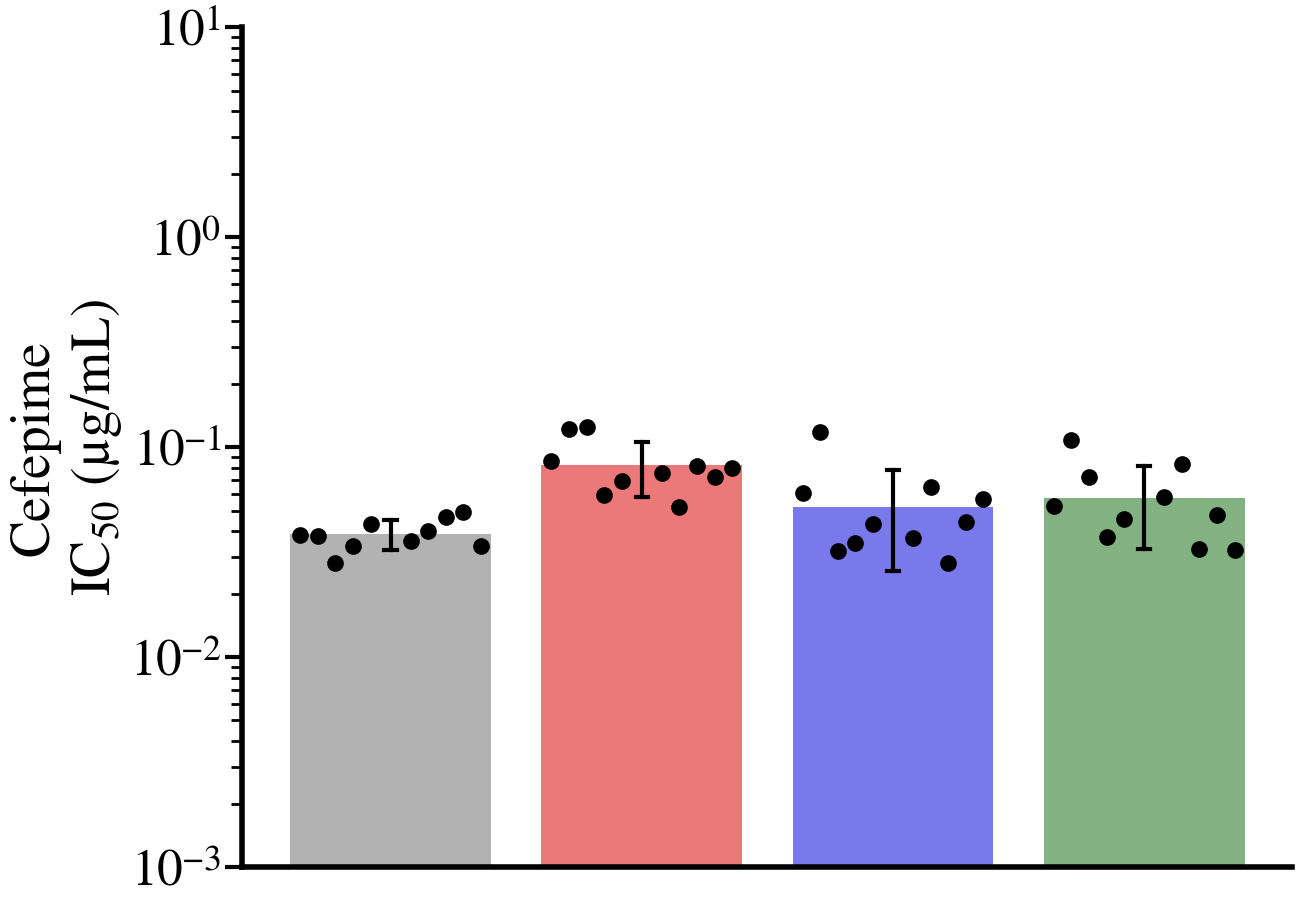

In [66]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Nimbus Roman"

######### NO LABELS
# Assign the antibiotic you want to graph
selected_antibiotic = "Cefepime"

# Subset the data for the selected antibiotic
subset_data = growth_features[growth_features['Antibiotic'] == selected_antibiotic].copy()  # Avoid SettingWithCopyWarning

# Custom y-axis limits for each antibiotic
custom_y_limits = {
    "Levofloxacin": (0.001, 10),
    "Amikacin": (.1, 1000),
    "Cefepime": (0.001, 10)
}

# Create a new column for the updated group labels
def assign_group_label(row):
    if row['group'] == "P":
        return r"MG"  # Just MG
    elif row['group'] == "PLA":
        return r"MG$^{\mathrm{LEV,AMI}}$"  # MG with AMI as superscript
    elif row['group'] == "PLAC":
        return r"MG$^{\mathrm{LEV,AMI,CEF}}$"  # MG with CEF as superscript
    elif row['group'] == "PL":
        return r"MG$^{\mathrm{LEV}}$"  # MG with LEV as superscript
    else:
        return "Unknown"

# Ensure the 'group' column exists
if 'group' not in subset_data.columns:
    subset_data['group'] = growth_features['Strain'].apply(lambda x: re.split(r'[1-9]', x)[0])

# Apply the function to create the new column
subset_data.loc[:, 'group_fancy'] = subset_data.apply(assign_group_label, axis=1)

# Update the palette to match the new group labels
group_palette = {
    r"MG": "grey",
    r"MG$^{\mathrm{LEV,AMI}}$": "blue",
    r"MG$^{\mathrm{LEV,AMI,CEF}}$": "forestgreen",
    r"MG$^{\mathrm{LEV}}$": "red",
}

# Use FacetGrid for plotting
g = sns.FacetGrid(
    subset_data,
    col="Antibiotic",  # Facet by Antibiotic
    sharey=False,  # Allow independent y-axis scaling
    height=10,  # Height of each facet
    aspect=1.5,  # Aspect ratio for width scaling
)

# Map bar plots to the grid
g.map(
    sns.barplot,
    "group_fancy",  # X-axis
    "IC50",  # Y-axis
    ci="sd",
    order=subset_data['group_fancy'].unique(),  # Ensure consistent x-axis order
    palette=group_palette,
    alpha=0.6,
    errcolor="black",  # Color of the error bars
    errwidth=3,  # Thickness of the error bars
    capsize=0.05  # Length of the caps on error bars
)

# Custom function to calculate evenly spaced x-positions
def get_evenly_spaced_positions(group_data, x_base, spread=0.36, gap=0.08):
    """
    Calculate evenly spaced x-positions around a central x_base, leaving a gap in the middle.

    Parameters:
        group_data: DataFrame containing points for a single category.
        x_base: Central x position for the category.
        spread: Maximum range to spread points around the center.
        gap: The size of the gap to leave in the middle (default: 0.1).

    Returns:
        List of adjusted x-positions for the points.
    """
    n_points = len(group_data)
    if n_points == 1:
        return [x_base]  # No need to spread if there's only one point

    half_points = n_points // 2  # Divide points into two halves
    if n_points % 2 == 0:
        # Even number of points
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        offsets = np.concatenate([left_offsets, right_offsets])
    else:
        # Odd number of points: one point stays at the center
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        center_offset = [0]  # Keep one point at the exact center
        offsets = np.concatenate([left_offsets, center_offset, right_offsets])

    return x_base + offsets

# Overlay strip plots with custom spacing
for group_fancy, group_data in subset_data.groupby('group_fancy'):
    x_base = subset_data['group_fancy'].unique().tolist().index(group_fancy)  # Base x position
    x_positions = get_evenly_spaced_positions(group_data, x_base)
    
    g.ax.scatter(
        x_positions,
        group_data['IC50'],
        color="black",
        facecolor="black",
        s=100,
        edgecolor="black",
        linewidth=2,
        zorder=10  # Ensure points are above other plot elements
    )


# Customizations for the y-axis and ticks
for ax in g.axes.flat:
    ax.set_yscale("log")  # Set log scale
    # Apply custom y-axis limits for the selected antibiotic
    if selected_antibiotic in custom_y_limits:
        ax.set_ylim(custom_y_limits[selected_antibiotic])
    # Let Seaborn/Matplotlib determine y-ticks automatically and just adjust their font size
    for label in ax.get_yticklabels():
        label.set_fontsize(37)  # Adjust font size for existing tick labels



 # Set x-tick positions and labels explicitly
    ax.set_xticks([])  # Remove tick positions
    ax.set_xticklabels([])  # Remove tick labels

    # Remove x-axis label
    ax.set_xlabel('')  # Remove x-axis label
    for spine in ax.spines.values():
        spine.set_linewidth(4)  # Set thickness of the spine lines

    ax.tick_params(axis='both', which='major', length=12, width=3)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=8, width=2)  # Minor ticks


# Add axis labels and facet titles
g.set_axis_labels("", "", fontsize=40)
g.set_axis_labels("", f"{selected_antibiotic}\nIC$_{{50}}$ (μg/mL)", fontsize=40)
g.set_titles("", size=50)  # Facet title uses the column value

# Adjust overall layout and spacing
g.fig.subplots_adjust(left=0.2, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
g.fig.set_size_inches(15, 10)  # Total figure size

# Save the plot (optional)
#g.savefig(f"{selected_antibiotic}_IC50_plot_1127.png", dpi=300, bbox_inches="tight")
g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures'/'finals'/'0512_finals' / f"{selected_antibiotic}_PLAC_IC50.png", dpi=600, bbox_inches="tight")
#g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / f'Cefepime_IC50_new', dpi=200, bbox_inches='tight')
# Show the plot
plt.show()


In [34]:
import pandas as pd
import itertools
import re
from scipy.stats import ttest_rel

# Assuming growth_features DataFrame is already defined
# Step 1: Create the 'group' and 'culturenumber' columns
growth_features['group'] = growth_features['Strain'].apply(lambda x: re.split(r'[1-9]', x)[0])
growth_features['culturenumber'] = growth_features['Strain'].apply(lambda x: re.search(r'(\d+)', x).group() if re.search(r'(\d+)', x) else None)

# Step 2: Initialize an empty list to store results and get all unique pairs of groups
unique_groups = growth_features['group'].unique()
group_pairs = list(itertools.combinations(unique_groups, 2))  # Generate all unique pairs of groups

# Step 3: Perform paired t-tests for each unique pair of groups within each antibiotic
results = []
for antibiotic in growth_features['Antibiotic'].unique():
    # Filter data by antibiotic
    antibiotic_data = growth_features[growth_features['Antibiotic'] == antibiotic]
    
    for group1, group2 in group_pairs:
        # Filter data for each group
        data1 = antibiotic_data[antibiotic_data['group'] == group1]
        data2 = antibiotic_data[antibiotic_data['group'] == group2]
        
        # Find common culture numbers by using set intersection
        common_culturenumbers = set(data1['culturenumber']).intersection(set(data2['culturenumber']))
        data1_common = data1[data1['culturenumber'].isin(common_culturenumbers)].set_index('culturenumber')
        data2_common = data2[data2['culturenumber'].isin(common_culturenumbers)].set_index('culturenumber')
        
        # Ensure paired data has matching indices (culturenumber)
        if not data1_common.empty and not data2_common.empty:
            ic50_group1 = data1_common['IC50']
            ic50_group2 = data2_common['IC50']
            
            # Perform paired t-test
            t_stat, p_value = ttest_rel(ic50_group1, ic50_group2)
            
            # Append results to list
            results.append({
                'Antibiotic': antibiotic,
                'Group1': group1,
                'Group2': group2,
                't_stat': t_stat,
                'p_value': p_value
            })

# Step 4: Convert results into a DataFrame
sig_growth_features = pd.DataFrame(results)

# Display or save the results
sig_growth_features # Print to check if results are populated


Antibiotic Group1 Group2    t_stat   p_value
0   Levofloxacin      P     PL -7.937193  0.000024
1   Levofloxacin      P    PLA -4.288740  0.002024
2   Levofloxacin      P   PLAC -4.048402  0.002892
3   Levofloxacin     PL    PLA  3.677300  0.005097
4   Levofloxacin     PL   PLAC  2.544634  0.031471
5   Levofloxacin    PLA   PLAC -1.100455  0.299695
6       Amikacin      P     PL -0.221086  0.829960
7       Amikacin      P    PLA -9.637648  0.000005
8       Amikacin      P   PLAC -3.177143  0.011236
9       Amikacin     PL    PLA -9.911805  0.000004
10      Amikacin     PL   PLAC -3.459387  0.007168
11      Amikacin    PLA   PLAC  6.563340  0.000104
12      Cefepime      P     PL -5.039182  0.000701
13      Cefepime      P    PLA -1.538828  0.158229
14      Cefepime      P   PLAC -2.189979  0.056252
15      Cefepime     PL    PLA  3.386612  0.008042
16      Cefepime     PL   PLAC  3.274291  0.009617
17      Cefepime    PLA   PLAC -0.893964  0.394618

In [35]:
import pandas as pd

# Step 1: Calculate the mean IC50 for each combination of Antibiotic and group
group_means = growth_features.groupby(['Antibiotic', 'group'])['IC50'].mean().reset_index()
group_means = group_means.rename(columns={'IC50': 'mean_IC50'})

# Step 2: Merge the means for Group1 and Group2 into sig_growth_features
sig_growth_features = sig_growth_features.merge(
    group_means, left_on=['Antibiotic', 'Group1'], right_on=['Antibiotic', 'group'], how='left'
).rename(columns={'mean_IC50': 'mean_IC50_Group1'}).drop(columns='group')

sig_growth_features = sig_growth_features.merge(
    group_means, left_on=['Antibiotic', 'Group2'], right_on=['Antibiotic', 'group'], how='left'
).rename(columns={'mean_IC50': 'mean_IC50_Group2'}).drop(columns='group')

# Display the filtered DataFrame
sig_growth_features

Antibiotic Group1 Group2    t_stat   p_value  mean_IC50_Group1  \
0   Levofloxacin      P     PL -7.937193  0.000024          0.036634   
1   Levofloxacin      P    PLA -4.288740  0.002024          0.036634   
2   Levofloxacin      P   PLAC -4.048402  0.002892          0.036634   
3   Levofloxacin     PL    PLA  3.677300  0.005097          1.374045   
4   Levofloxacin     PL   PLAC  2.544634  0.031471          1.374045   
5   Levofloxacin    PLA   PLAC -1.100455  0.299695          0.614716   
6       Amikacin      P     PL -0.221086  0.829960          3.072001   
7       Amikacin      P    PLA -9.637648  0.000005          3.072001   
8       Amikacin      P   PLAC -3.177143  0.011236          3.072001   
9       Amikacin     PL    PLA -9.911805  0.000004          3.173507   
10      Amikacin     PL   PLAC -3.459387  0.007168          3.173507   
11      Amikacin    PLA   PLAC  6.563340  0.000104         26.228007   
12      Cefepime      P     PL -5.039182  0.000701          0.038663   
13      Cefepime      P    PLA -1.538828  0.158229          0.038663   
14      Cefepime      P   PLAC -2.189979  0.056252          0.038663   
15      Cefepime     PL    PLA  3.386612  0.008042          0.082337   
16      Cefepime     PL   PLAC  3.274291  0.009617          0.082337   
17      Cefepime    PLA   PLAC -0.893964  0.394618          0.051923   

    mean_IC50_Group2  
0           1.374045  
1           0.614716  
2           0.754383  
3           0.614716  
4           0.754383  
5           0.754383  
6           3.173507  
7          26.228007  
8           9.420465  
9          26.228007  
10          9.420465  
11          9.420465  
12          0.082337  
13          0.051923  
14          0.057084  
15          0.051923  
16          0.057084  
17          0.057084

In [26]:
summary_stats = (
    growth_features.groupby(['group', 'Antibiotic'])
    .agg(mean_IC50=('IC50', 'mean'), sd_IC50=('IC50', 'std'))
    .reset_index()
)
summary_stats

group    Antibiotic  mean_IC50   sd_IC50
0      P      Amikacin   3.072001  0.771780
1      P      Cefepime   0.038663  0.006385
2      P  Levofloxacin   0.036634  0.009053
3     PL      Amikacin   3.173507  1.247111
4     PL      Cefepime   0.082337  0.024199
5     PL  Levofloxacin   1.374045  0.530789
6    PLA      Amikacin  26.228007  7.863665
7    PLA      Cefepime   0.051923  0.026288
8    PLA  Levofloxacin   0.614716  0.425567
9   PLAC      Amikacin   9.420465  6.151592
10  PLAC      Cefepime   0.057084  0.024439
11  PLAC  Levofloxacin   0.754383  0.558836